# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# # PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# # FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('se_resnext50_augnew_1e-4_imagenet')

TH = 40.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 33 s, sys: 30.7 s, total: 1min 3s
Wall time: 6.77 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('TH', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

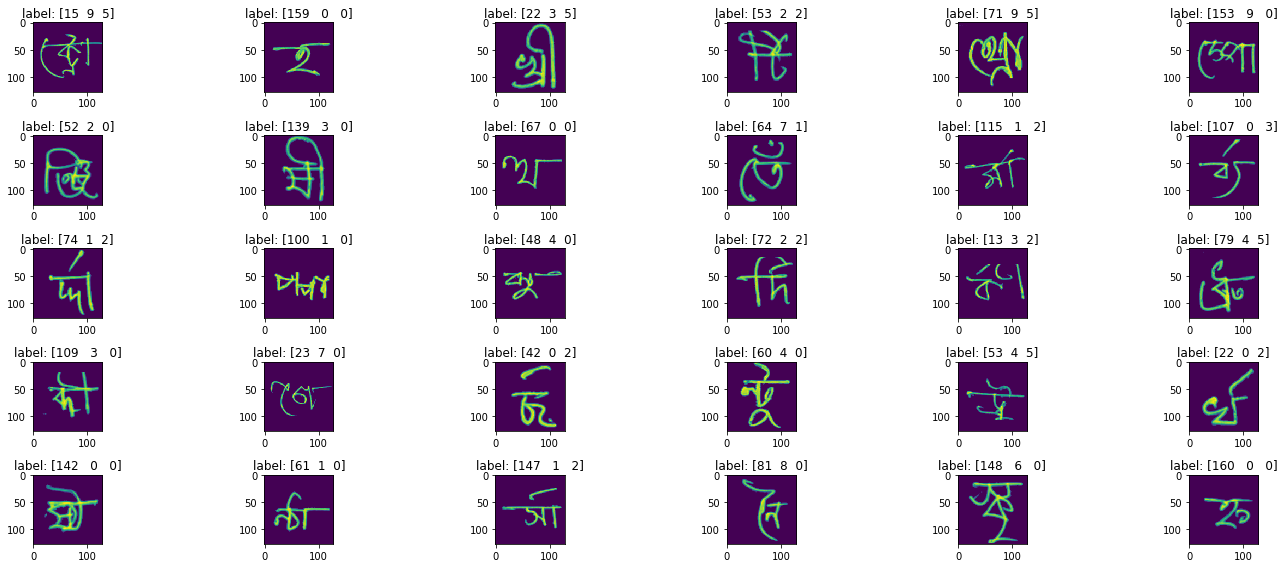

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.15
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def crop_char_image_new(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0 > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

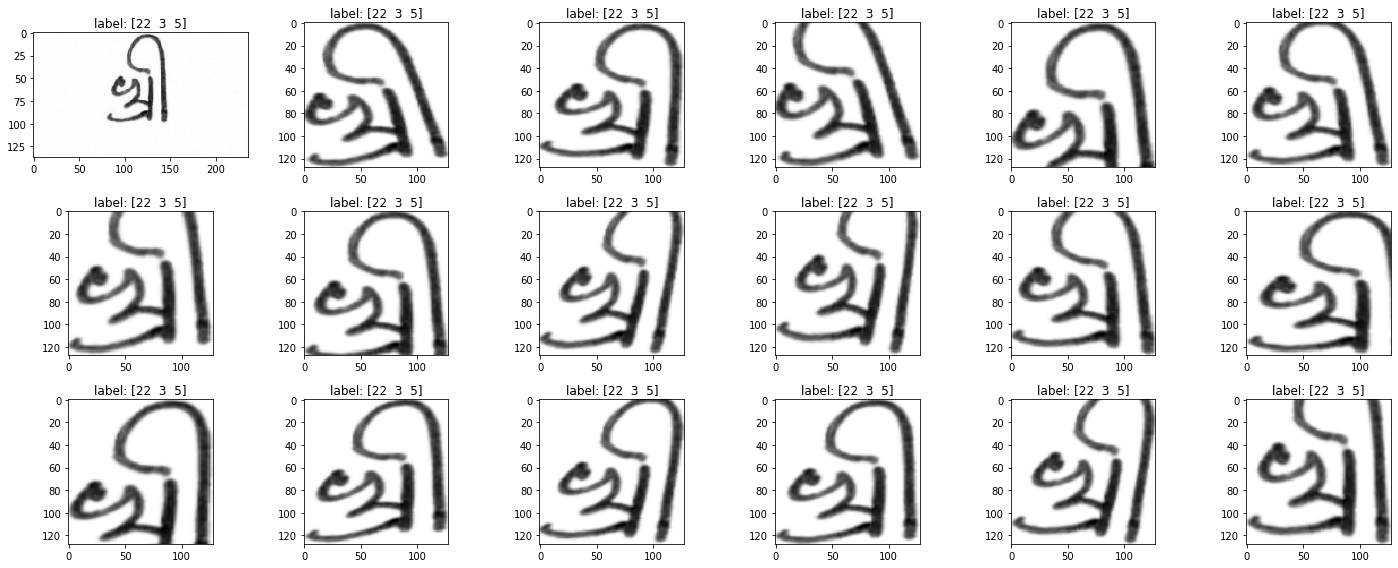

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

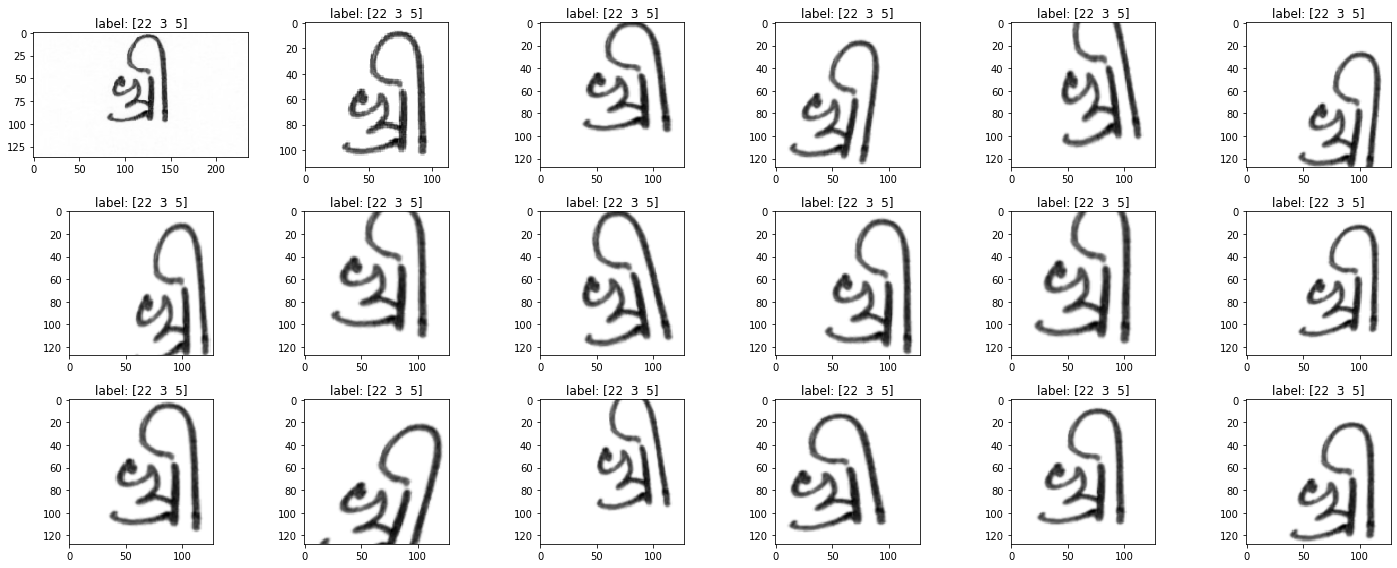

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

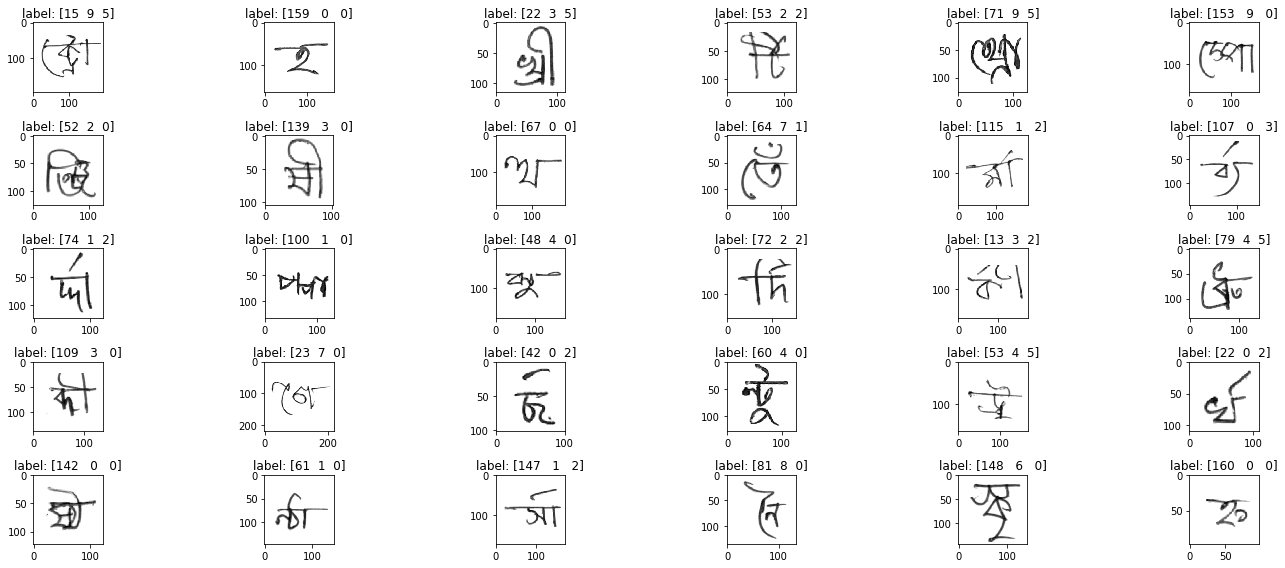

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

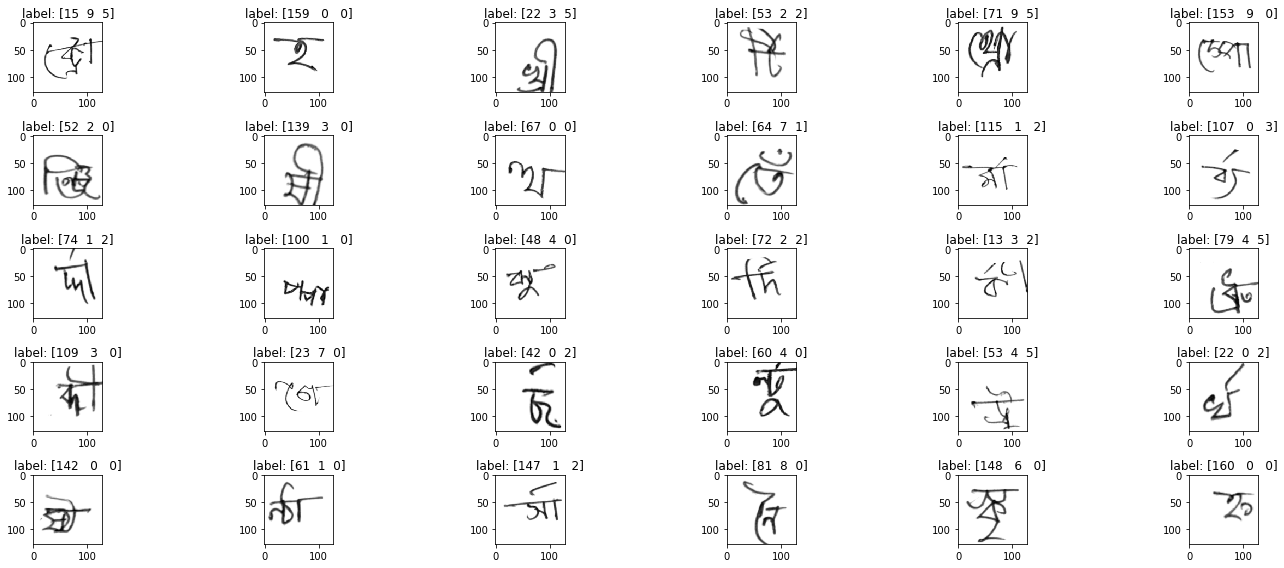

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=32, max_w_size=32, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
    piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

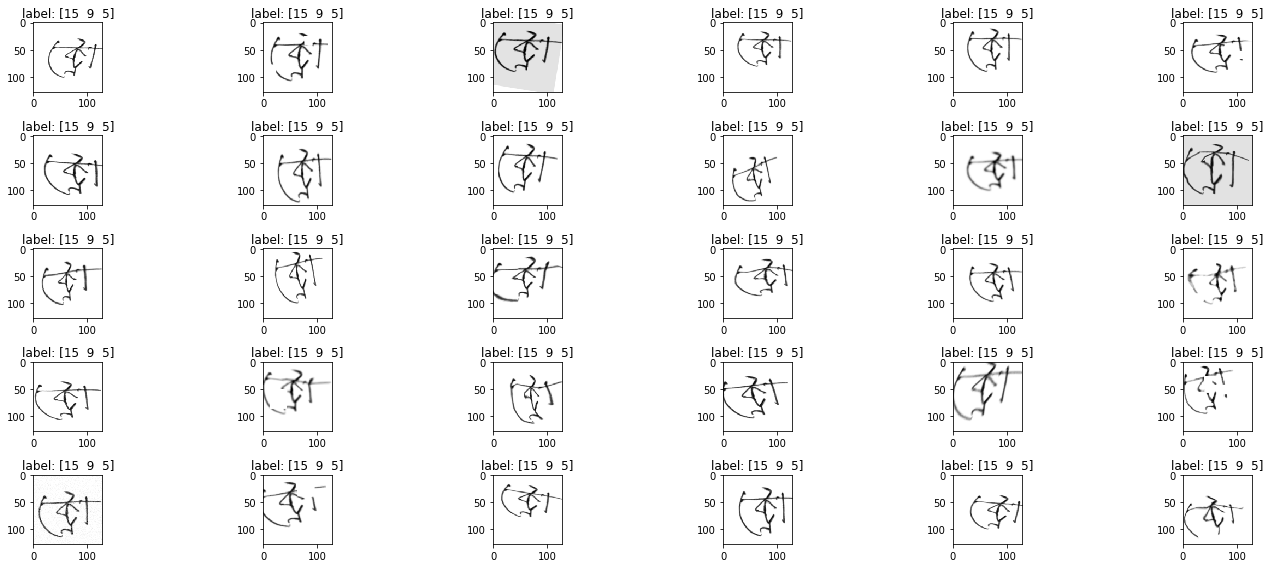

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

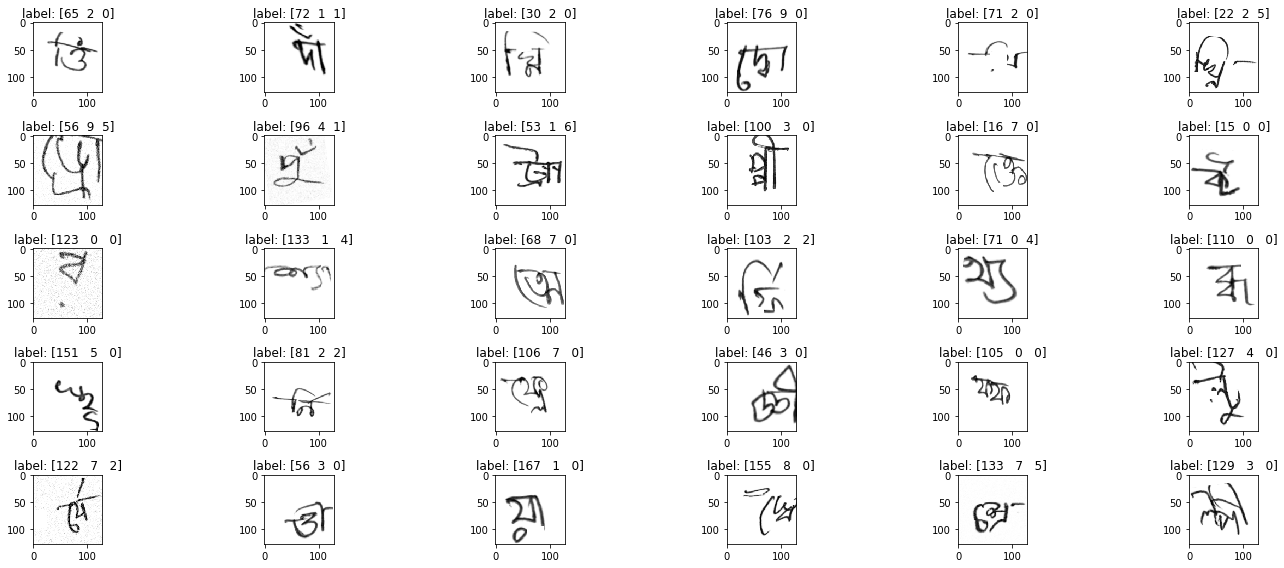

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

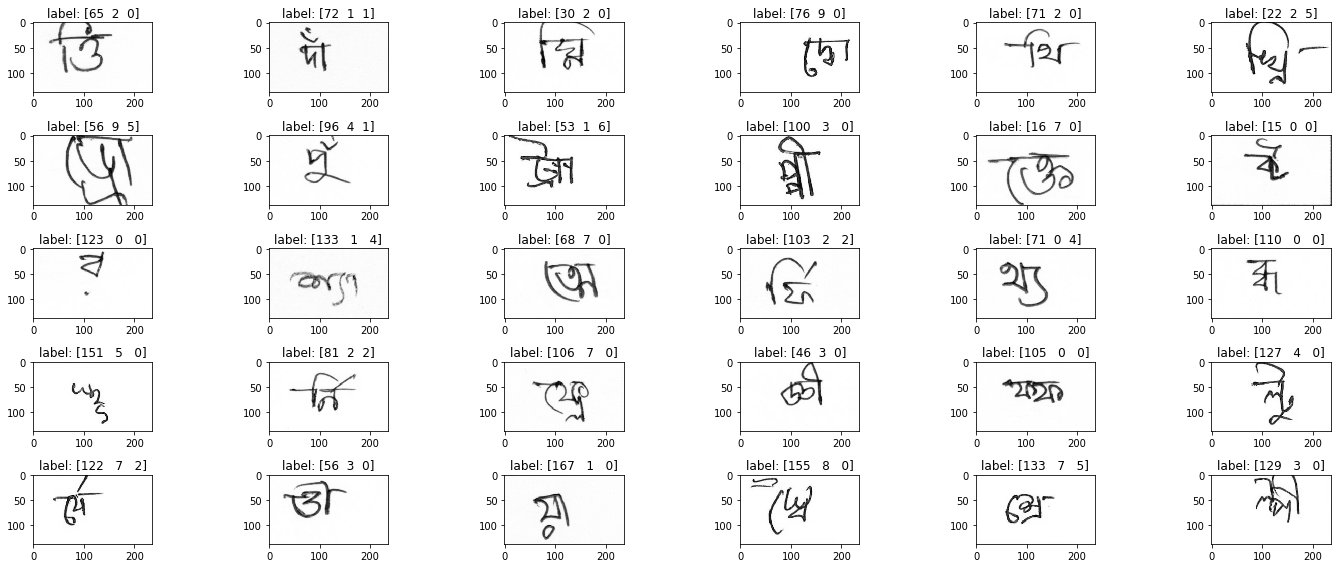

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [28]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
a = np.array([2,3])
b = np.array([4,5,6])

In [31]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [32]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [33]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [34]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [35]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [36]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [37]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [38]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [39]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [40]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [41]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [42]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [43]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [44]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [45]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

In [46]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

In [47]:
# import os
# a = "."
# b = os.path.join(a,"{}_fold".format(2))
# if not os.path.exists(b):
#     os.mkdir(b)
# print(b)
# c = os.path.join(b, 'log.json')
# print(c)

In [48]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [49]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

100%|██████████| 419/419 [01:02<00:00,  6.68it/s]


epoch      0 train/loss  5.777398 train/loss_grapheme  3.187414 train/loss_vowel  1.273990 train/loss_consonant  1.315995 train/acc_grapheme  0.429596 train/acc_vowel  0.798571 train/acc_consonant  0.815463 train/recall  0.523706 val/loss  3.347084 val/loss_grapheme  1.468762 val/loss_vowel  0.853796 val/loss_consonant  1.024526 val/acc_grapheme  0.828172 val/acc_vowel  0.969453 val/acc_consonant  0.963354 val/recall  0.827728 lr  0.000100 elapsed_time  610.399789 mode 011 


100%|██████████| 419/419 [01:00<00:00,  6.89it/s]


epoch      1 train/loss  3.522813 train/loss_grapheme  1.780103 train/loss_vowel  0.806780 train/loss_consonant  0.935930 train/acc_grapheme  0.775885 train/acc_vowel  0.948062 train/acc_consonant  0.950197 train/recall  0.789775 val/loss  2.153477 val/loss_grapheme  0.803671 val/loss_vowel  0.597634 val/loss_consonant  0.752171 val/acc_grapheme  0.915206 val/acc_vowel  0.979187 val/acc_consonant  0.977196 val/recall  0.909406 lr  0.000100 elapsed_time  1215.186012 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  2.594883 train/loss_grapheme  1.299634 train/loss_vowel  0.590428 train/loss_consonant  0.704822 train/acc_grapheme  0.848766 train/acc_vowel  0.959570 train/acc_consonant  0.962775 train/recall  0.851089 val/loss  1.552481 val/loss_grapheme  0.572259 val/loss_vowel  0.421618 val/loss_consonant  0.558603 val/acc_grapheme  0.927480 val/acc_vowel  0.984440 val/acc_consonant  0.979536 val/recall  0.924724 lr  0.000100 elapsed_time  1820.524919 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  1.977650 train/loss_grapheme  1.004438 train/loss_vowel  0.441727 train/loss_consonant  0.531484 train/acc_grapheme  0.877185 train/acc_vowel  0.965190 train/acc_consonant  0.968227 train/recall  0.878158 val/loss  1.132791 val/loss_grapheme  0.416261 val/loss_vowel  0.303046 val/loss_consonant  0.413484 val/acc_grapheme  0.939952 val/acc_vowel  0.985685 val/acc_consonant  0.983519 val/recall  0.937016 lr  0.000100 elapsed_time  2429.000562 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  1.540377 train/loss_grapheme  0.801410 train/loss_vowel  0.337512 train/loss_consonant  0.401455 train/acc_grapheme  0.894437 train/acc_vowel  0.968246 train/acc_consonant  0.971202 train/recall  0.894863 val/loss  0.886373 val/loss_grapheme  0.354608 val/loss_vowel  0.219025 val/loss_consonant  0.312740 val/acc_grapheme  0.944384 val/acc_vowel  0.985386 val/acc_consonant  0.984191 val/recall  0.943193 lr  0.000100 elapsed_time  3034.055871 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  1.240977 train/loss_grapheme  0.669040 train/loss_vowel  0.265852 train/loss_consonant  0.306085 train/acc_grapheme  0.904109 train/acc_vowel  0.970866 train/acc_consonant  0.974271 train/recall  0.903727 val/loss  0.710686 val/loss_grapheme  0.310064 val/loss_vowel  0.172469 val/loss_consonant  0.228153 val/acc_grapheme  0.945355 val/acc_vowel  0.987577 val/acc_consonant  0.984341 val/recall  0.944299 lr  0.000100 elapsed_time  3640.987630 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  1.017506 train/loss_grapheme  0.563982 train/loss_vowel  0.215418 train/loss_consonant  0.238105 train/acc_grapheme  0.913040 train/acc_vowel  0.972957 train/acc_consonant  0.975391 train/recall  0.912253 val/loss  0.588417 val/loss_grapheme  0.277395 val/loss_vowel  0.135176 val/loss_consonant  0.175845 val/acc_grapheme  0.950309 val/acc_vowel  0.985984 val/acc_consonant  0.984490 val/recall  0.947711 lr  0.000100 elapsed_time  4247.077401 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.868109 train/loss_grapheme  0.498148 train/loss_vowel  0.180105 train/loss_consonant  0.189856 train/acc_grapheme  0.917814 train/acc_vowel  0.974084 train/acc_consonant  0.976779 train/recall  0.916740 val/loss  0.511972 val/loss_grapheme  0.259039 val/loss_vowel  0.113004 val/loss_consonant  0.139929 val/acc_grapheme  0.951927 val/acc_vowel  0.986880 val/acc_consonant  0.985486 val/recall  0.949264 lr  0.000100 elapsed_time  4853.312202 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.755862 train/loss_grapheme  0.446629 train/loss_vowel  0.154167 train/loss_consonant  0.155067 train/acc_grapheme  0.922463 train/acc_vowel  0.975129 train/acc_consonant  0.977843 train/recall  0.922099 val/loss  0.467956 val/loss_grapheme  0.258459 val/loss_vowel  0.094981 val/loss_consonant  0.114517 val/acc_grapheme  0.950657 val/acc_vowel  0.987204 val/acc_consonant  0.986507 val/recall  0.949079 lr  0.000100 elapsed_time  5455.997228 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.668795 train/loss_grapheme  0.403962 train/loss_vowel  0.135306 train/loss_consonant  0.129527 train/acc_grapheme  0.926926 train/acc_vowel  0.975876 train/acc_consonant  0.978864 train/recall  0.925990 val/loss  0.422322 val/loss_grapheme  0.247789 val/loss_vowel  0.079874 val/loss_consonant  0.094659 val/acc_grapheme  0.951927 val/acc_vowel  0.987826 val/acc_consonant  0.985635 val/recall  0.950662 lr  0.000100 elapsed_time  6061.051557 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.608995 train/loss_grapheme  0.371739 train/loss_vowel  0.122842 train/loss_consonant  0.114414 train/acc_grapheme  0.930137 train/acc_vowel  0.975970 train/acc_consonant  0.978714 train/recall  0.928084 val/loss  0.396174 val/loss_grapheme  0.240459 val/loss_vowel  0.071980 val/loss_consonant  0.083735 val/acc_grapheme  0.951952 val/acc_vowel  0.987801 val/acc_consonant  0.985386 val/recall  0.950649 lr  0.000100 elapsed_time  6669.928225 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.555804 train/loss_grapheme  0.346267 train/loss_vowel  0.110838 train/loss_consonant  0.098699 train/acc_grapheme  0.932733 train/acc_vowel  0.977152 train/acc_consonant  0.980314 train/recall  0.931230 val/loss  0.363066 val/loss_grapheme  0.225905 val/loss_vowel  0.064228 val/loss_consonant  0.072933 val/acc_grapheme  0.954616 val/acc_vowel  0.988399 val/acc_consonant  0.986955 val/recall  0.952557 lr  0.000100 elapsed_time  7276.878310 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.514117 train/loss_grapheme  0.323380 train/loss_vowel  0.101191 train/loss_consonant  0.089546 train/acc_grapheme  0.935371 train/acc_vowel  0.978596 train/acc_consonant  0.980526 train/recall  0.934691 val/loss  0.352577 val/loss_grapheme  0.224597 val/loss_vowel  0.061417 val/loss_consonant  0.066563 val/acc_grapheme  0.954367 val/acc_vowel  0.988125 val/acc_consonant  0.986781 val/recall  0.953291 lr  0.000100 elapsed_time  7879.042774 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.487090 train/loss_grapheme  0.307329 train/loss_vowel  0.096464 train/loss_consonant  0.083297 train/acc_grapheme  0.937089 train/acc_vowel  0.978329 train/acc_consonant  0.980949 train/recall  0.935219 val/loss  0.346119 val/loss_grapheme  0.226012 val/loss_vowel  0.058163 val/loss_consonant  0.061943 val/acc_grapheme  0.954815 val/acc_vowel  0.988922 val/acc_consonant  0.987229 val/recall  0.953506 lr  0.000100 elapsed_time  8482.291485 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.456025 train/loss_grapheme  0.288923 train/loss_vowel  0.090696 train/loss_consonant  0.076406 train/acc_grapheme  0.939305 train/acc_vowel  0.979343 train/acc_consonant  0.981839 train/recall  0.937408 val/loss  0.325528 val/loss_grapheme  0.211674 val/loss_vowel  0.056013 val/loss_consonant  0.057841 val/acc_grapheme  0.956557 val/acc_vowel  0.988449 val/acc_consonant  0.986706 val/recall  0.953952 lr  0.000100 elapsed_time  9085.467273 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.434867 train/loss_grapheme  0.274792 train/loss_vowel  0.087422 train/loss_consonant  0.072653 train/acc_grapheme  0.941222 train/acc_vowel  0.979617 train/acc_consonant  0.982262 train/recall  0.939010 val/loss  0.320480 val/loss_grapheme  0.209199 val/loss_vowel  0.053756 val/loss_consonant  0.057525 val/acc_grapheme  0.957155 val/acc_vowel  0.988996 val/acc_consonant  0.986805 val/recall  0.954062 lr  0.000100 elapsed_time  9693.998538 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.413802 train/loss_grapheme  0.261484 train/loss_vowel  0.083729 train/loss_consonant  0.068589 train/acc_grapheme  0.943805 train/acc_vowel  0.979922 train/acc_consonant  0.982922 train/recall  0.941384 val/loss  0.323028 val/loss_grapheme  0.213742 val/loss_vowel  0.054008 val/loss_consonant  0.055278 val/acc_grapheme  0.956109 val/acc_vowel  0.988648 val/acc_consonant  0.986830 val/recall  0.953458 lr  0.000100 elapsed_time  10300.080005 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.397534 train/loss_grapheme  0.250044 train/loss_vowel  0.081618 train/loss_consonant  0.065872 train/acc_grapheme  0.945074 train/acc_vowel  0.979785 train/acc_consonant  0.983171 train/recall  0.942594 val/loss  0.308003 val/loss_grapheme  0.203444 val/loss_vowel  0.052517 val/loss_consonant  0.052041 val/acc_grapheme  0.956632 val/acc_vowel  0.989071 val/acc_consonant  0.987727 val/recall  0.954986 lr  0.000100 elapsed_time  10903.653276 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.382509 train/loss_grapheme  0.239723 train/loss_vowel  0.078927 train/loss_consonant  0.063859 train/acc_grapheme  0.946892 train/acc_vowel  0.980557 train/acc_consonant  0.983152 train/recall  0.944564 val/loss  0.314360 val/loss_grapheme  0.209065 val/loss_vowel  0.050416 val/loss_consonant  0.054879 val/acc_grapheme  0.956682 val/acc_vowel  0.989121 val/acc_consonant  0.986756 val/recall  0.954576 lr  0.000100 elapsed_time  11512.390541 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.370838 train/loss_grapheme  0.233461 train/loss_vowel  0.074569 train/loss_consonant  0.062807 train/acc_grapheme  0.947900 train/acc_vowel  0.981528 train/acc_consonant  0.983569 train/recall  0.944732 val/loss  0.295351 val/loss_grapheme  0.197119 val/loss_vowel  0.047812 val/loss_consonant  0.050420 val/acc_grapheme  0.958400 val/acc_vowel  0.989345 val/acc_consonant  0.986980 val/recall  0.956708 lr  0.000100 elapsed_time  12118.598615 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.361018 train/loss_grapheme  0.227659 train/loss_vowel  0.073476 train/loss_consonant  0.059883 train/acc_grapheme  0.948043 train/acc_vowel  0.981447 train/acc_consonant  0.984185 train/recall  0.945819 val/loss  0.305305 val/loss_grapheme  0.204712 val/loss_vowel  0.049707 val/loss_consonant  0.050887 val/acc_grapheme  0.956010 val/acc_vowel  0.988897 val/acc_consonant  0.987428 val/recall  0.953677 lr  0.000100 elapsed_time  12723.633182 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.350849 train/loss_grapheme  0.220162 train/loss_vowel  0.070747 train/loss_consonant  0.059940 train/acc_grapheme  0.949599 train/acc_vowel  0.981777 train/acc_consonant  0.983824 train/recall  0.947182 val/loss  0.297714 val/loss_grapheme  0.202062 val/loss_vowel  0.047259 val/loss_consonant  0.048394 val/acc_grapheme  0.957354 val/acc_vowel  0.989320 val/acc_consonant  0.988200 val/recall  0.955803 lr  0.000100 elapsed_time  13330.015668 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.345566 train/loss_grapheme  0.215697 train/loss_vowel  0.071214 train/loss_consonant  0.058655 train/acc_grapheme  0.950060 train/acc_vowel  0.981590 train/acc_consonant  0.984179 train/recall  0.947701 val/loss  0.300897 val/loss_grapheme  0.200395 val/loss_vowel  0.049641 val/loss_consonant  0.050861 val/acc_grapheme  0.956084 val/acc_vowel  0.988523 val/acc_consonant  0.986407 val/recall  0.953099 lr  0.000100 elapsed_time  13936.191863 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.332049 train/loss_grapheme  0.207454 train/loss_vowel  0.067695 train/loss_consonant  0.056900 train/acc_grapheme  0.951385 train/acc_vowel  0.982499 train/acc_consonant  0.984428 train/recall  0.948728 val/loss  0.280382 val/loss_grapheme  0.191477 val/loss_vowel  0.044051 val/loss_consonant  0.044854 val/acc_grapheme  0.957678 val/acc_vowel  0.990117 val/acc_consonant  0.988772 val/recall  0.957646 lr  0.000100 elapsed_time  14548.858948 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.327596 train/loss_grapheme  0.205143 train/loss_vowel  0.067487 train/loss_consonant  0.054966 train/acc_grapheme  0.951927 train/acc_vowel  0.982318 train/acc_consonant  0.984932 train/recall  0.949596 val/loss  0.295289 val/loss_grapheme  0.200023 val/loss_vowel  0.047757 val/loss_consonant  0.047509 val/acc_grapheme  0.956184 val/acc_vowel  0.989395 val/acc_consonant  0.988075 val/recall  0.954379 lr  0.000100 elapsed_time  15159.278196 mode 000 


100%|██████████| 419/419 [01:02<00:00,  6.72it/s]


epoch     25 train/loss  0.321441 train/loss_grapheme  0.198405 train/loss_vowel  0.067614 train/loss_consonant  0.055423 train/acc_grapheme  0.952736 train/acc_vowel  0.982225 train/acc_consonant  0.984615 train/recall  0.950237 val/loss  0.302257 val/loss_grapheme  0.198742 val/loss_vowel  0.053636 val/loss_consonant  0.049879 val/acc_grapheme  0.956582 val/acc_vowel  0.987976 val/acc_consonant  0.987154 val/recall  0.955132 lr  0.000100 elapsed_time  15776.328692 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.310266 train/loss_grapheme  0.192228 train/loss_vowel  0.064044 train/loss_consonant  0.053993 train/acc_grapheme  0.954697 train/acc_vowel  0.983071 train/acc_consonant  0.985137 train/recall  0.951266 val/loss  0.283904 val/loss_grapheme  0.191697 val/loss_vowel  0.044024 val/loss_consonant  0.048182 val/acc_grapheme  0.957977 val/acc_vowel  0.989992 val/acc_consonant  0.987652 val/recall  0.956430 lr  0.000100 elapsed_time  16389.350603 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.305737 train/loss_grapheme  0.188850 train/loss_vowel  0.063534 train/loss_consonant  0.053354 train/acc_grapheme  0.954566 train/acc_vowel  0.983395 train/acc_consonant  0.985312 train/recall  0.951738 val/loss  0.290120 val/loss_grapheme  0.194476 val/loss_vowel  0.046977 val/loss_consonant  0.048667 val/acc_grapheme  0.958599 val/acc_vowel  0.988971 val/acc_consonant  0.987751 val/recall  0.956802 lr  0.000100 elapsed_time  16996.742651 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.300247 train/loss_grapheme  0.186204 train/loss_vowel  0.062666 train/loss_consonant  0.051377 train/acc_grapheme  0.954746 train/acc_vowel  0.983451 train/acc_consonant  0.985859 train/recall  0.952409 val/loss  0.284896 val/loss_grapheme  0.190386 val/loss_vowel  0.045347 val/loss_consonant  0.049162 val/acc_grapheme  0.958923 val/acc_vowel  0.989594 val/acc_consonant  0.988249 val/recall  0.957565 lr  0.000100 elapsed_time  17608.392470 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.296123 train/loss_grapheme  0.183197 train/loss_vowel  0.062722 train/loss_consonant  0.050204 train/acc_grapheme  0.955412 train/acc_vowel  0.983115 train/acc_consonant  0.985710 train/recall  0.953273 val/loss  0.286842 val/loss_grapheme  0.189185 val/loss_vowel  0.048092 val/loss_consonant  0.049566 val/acc_grapheme  0.958574 val/acc_vowel  0.988897 val/acc_consonant  0.987727 val/recall  0.956239 lr  0.000100 elapsed_time  18214.227889 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.288433 train/loss_grapheme  0.178612 train/loss_vowel  0.060236 train/loss_consonant  0.049584 train/acc_grapheme  0.956116 train/acc_vowel  0.984030 train/acc_consonant  0.986152 train/recall  0.953469 val/loss  0.287860 val/loss_grapheme  0.190259 val/loss_vowel  0.049208 val/loss_consonant  0.048394 val/acc_grapheme  0.957354 val/acc_vowel  0.988548 val/acc_consonant  0.988025 val/recall  0.955531 lr  0.000100 elapsed_time  18821.099105 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.286730 train/loss_grapheme  0.176431 train/loss_vowel  0.060706 train/loss_consonant  0.049593 train/acc_grapheme  0.956638 train/acc_vowel  0.983712 train/acc_consonant  0.986332 train/recall  0.954023 val/loss  0.279118 val/loss_grapheme  0.187608 val/loss_vowel  0.045922 val/loss_consonant  0.045589 val/acc_grapheme  0.958599 val/acc_vowel  0.989220 val/acc_consonant  0.988473 val/recall  0.956434 lr  0.000100 elapsed_time  19425.614837 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.283085 train/loss_grapheme  0.172964 train/loss_vowel  0.061238 train/loss_consonant  0.048882 train/acc_grapheme  0.957217 train/acc_vowel  0.983040 train/acc_consonant  0.986220 train/recall  0.954414 val/loss  0.278795 val/loss_grapheme  0.187690 val/loss_vowel  0.045944 val/loss_consonant  0.045161 val/acc_grapheme  0.958599 val/acc_vowel  0.988946 val/acc_consonant  0.988249 val/recall  0.956960 lr  0.000100 elapsed_time  20034.201170 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.280555 train/loss_grapheme  0.171391 train/loss_vowel  0.060107 train/loss_consonant  0.049057 train/acc_grapheme  0.957696 train/acc_vowel  0.983762 train/acc_consonant  0.985940 train/recall  0.955112 val/loss  0.288420 val/loss_grapheme  0.193470 val/loss_vowel  0.044660 val/loss_consonant  0.050289 val/acc_grapheme  0.957080 val/acc_vowel  0.989619 val/acc_consonant  0.987453 val/recall  0.955533 lr  0.000100 elapsed_time  20639.014060 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.273624 train/loss_grapheme  0.166703 train/loss_vowel  0.058059 train/loss_consonant  0.048862 train/acc_grapheme  0.959091 train/acc_vowel  0.983830 train/acc_consonant  0.986276 train/recall  0.956302 val/loss  0.280444 val/loss_grapheme  0.187859 val/loss_vowel  0.045016 val/loss_consonant  0.047569 val/acc_grapheme  0.958176 val/acc_vowel  0.989693 val/acc_consonant  0.987851 val/recall  0.956986 lr  0.000100 elapsed_time  21242.308570 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.271188 train/loss_grapheme  0.165353 train/loss_vowel  0.057923 train/loss_consonant  0.047912 train/acc_grapheme  0.958524 train/acc_vowel  0.984428 train/acc_consonant  0.986494 train/recall  0.956055 val/loss  0.274975 val/loss_grapheme  0.181850 val/loss_vowel  0.047711 val/loss_consonant  0.045414 val/acc_grapheme  0.959769 val/acc_vowel  0.988673 val/acc_consonant  0.988299 val/recall  0.956681 lr  0.000100 elapsed_time  21847.974412 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.268256 train/loss_grapheme  0.163509 train/loss_vowel  0.057443 train/loss_consonant  0.047304 train/acc_grapheme  0.959346 train/acc_vowel  0.984098 train/acc_consonant  0.986768 train/recall  0.956048 val/loss  0.282991 val/loss_grapheme  0.188397 val/loss_vowel  0.045117 val/loss_consonant  0.049477 val/acc_grapheme  0.959122 val/acc_vowel  0.989395 val/acc_consonant  0.987229 val/recall  0.957101 lr  0.000100 elapsed_time  22452.201245 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.259611 train/loss_grapheme  0.158643 train/loss_vowel  0.055355 train/loss_consonant  0.045613 train/acc_grapheme  0.960236 train/acc_vowel  0.984888 train/acc_consonant  0.987098 train/recall  0.957856 val/loss  0.283860 val/loss_grapheme  0.188496 val/loss_vowel  0.048600 val/loss_consonant  0.046765 val/acc_grapheme  0.957528 val/acc_vowel  0.988374 val/acc_consonant  0.988224 val/recall  0.954470 lr  0.000100 elapsed_time  23057.360525 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.258576 train/loss_grapheme  0.156707 train/loss_vowel  0.055372 train/loss_consonant  0.046497 train/acc_grapheme  0.960566 train/acc_vowel  0.984907 train/acc_consonant  0.986942 train/recall  0.957773 val/loss  0.275374 val/loss_grapheme  0.183094 val/loss_vowel  0.046368 val/loss_consonant  0.045912 val/acc_grapheme  0.958275 val/acc_vowel  0.989220 val/acc_consonant  0.988175 val/recall  0.955906 lr  0.000100 elapsed_time  23660.113653 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.254026 train/loss_grapheme  0.154369 train/loss_vowel  0.054987 train/loss_consonant  0.044670 train/acc_grapheme  0.960827 train/acc_vowel  0.984702 train/acc_consonant  0.987247 train/recall  0.957761 val/loss  0.271693 val/loss_grapheme  0.181640 val/loss_vowel  0.043160 val/loss_consonant  0.046893 val/acc_grapheme  0.959047 val/acc_vowel  0.990092 val/acc_consonant  0.988324 val/recall  0.956099 lr  0.000100 elapsed_time  24263.162890 mode 110 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.251024 train/loss_grapheme  0.151929 train/loss_vowel  0.054199 train/loss_consonant  0.044896 train/acc_grapheme  0.961593 train/acc_vowel  0.984982 train/acc_consonant  0.987341 train/recall  0.958744 val/loss  0.281323 val/loss_grapheme  0.188926 val/loss_vowel  0.045084 val/loss_consonant  0.047313 val/acc_grapheme  0.957752 val/acc_vowel  0.989370 val/acc_consonant  0.988125 val/recall  0.955470 lr  0.000100 elapsed_time  24867.021664 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.247626 train/loss_grapheme  0.149990 train/loss_vowel  0.053246 train/loss_consonant  0.044390 train/acc_grapheme  0.962259 train/acc_vowel  0.985386 train/acc_consonant  0.987229 train/recall  0.959447 val/loss  0.278864 val/loss_grapheme  0.187924 val/loss_vowel  0.044631 val/loss_consonant  0.046309 val/acc_grapheme  0.957852 val/acc_vowel  0.989195 val/acc_consonant  0.988249 val/recall  0.956242 lr  0.000100 elapsed_time  25472.217917 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.248489 train/loss_grapheme  0.150926 train/loss_vowel  0.054640 train/loss_consonant  0.042922 train/acc_grapheme  0.960846 train/acc_vowel  0.984870 train/acc_consonant  0.987770 train/recall  0.958003 val/loss  0.289928 val/loss_grapheme  0.192622 val/loss_vowel  0.048137 val/loss_consonant  0.049170 val/acc_grapheme  0.956358 val/acc_vowel  0.988573 val/acc_consonant  0.987627 val/recall  0.954745 lr  0.000100 elapsed_time  26075.558589 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.247729 train/loss_grapheme  0.149920 train/loss_vowel  0.053325 train/loss_consonant  0.044484 train/acc_grapheme  0.961705 train/acc_vowel  0.985274 train/acc_consonant  0.987216 train/recall  0.958754 val/loss  0.276974 val/loss_grapheme  0.185813 val/loss_vowel  0.044446 val/loss_consonant  0.046716 val/acc_grapheme  0.958250 val/acc_vowel  0.989668 val/acc_consonant  0.988697 val/recall  0.955748 lr  0.000100 elapsed_time  26680.638352 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.238357 train/loss_grapheme  0.142914 train/loss_vowel  0.051974 train/loss_consonant  0.043468 train/acc_grapheme  0.963541 train/acc_vowel  0.985554 train/acc_consonant  0.987359 train/recall  0.960230 val/loss  0.278580 val/loss_grapheme  0.186352 val/loss_vowel  0.044443 val/loss_consonant  0.047785 val/acc_grapheme  0.958026 val/acc_vowel  0.989718 val/acc_consonant  0.987652 val/recall  0.956633 lr  0.000100 elapsed_time  27286.166294 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.244470 train/loss_grapheme  0.148118 train/loss_vowel  0.052774 train/loss_consonant  0.043578 train/acc_grapheme  0.962420 train/acc_vowel  0.985467 train/acc_consonant  0.987434 train/recall  0.960143 val/loss  0.277847 val/loss_grapheme  0.186413 val/loss_vowel  0.045149 val/loss_consonant  0.046285 val/acc_grapheme  0.958101 val/acc_vowel  0.989892 val/acc_consonant  0.988424 val/recall  0.956770 lr  0.000100 elapsed_time  27890.392816 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.239865 train/loss_grapheme  0.143727 train/loss_vowel  0.052522 train/loss_consonant  0.043617 train/acc_grapheme  0.963522 train/acc_vowel  0.985274 train/acc_consonant  0.987490 train/recall  0.960840 val/loss  0.278340 val/loss_grapheme  0.186425 val/loss_vowel  0.046330 val/loss_consonant  0.045585 val/acc_grapheme  0.957055 val/acc_vowel  0.988847 val/acc_consonant  0.988623 val/recall  0.955231 lr  0.000100 elapsed_time  28491.903637 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.234523 train/loss_grapheme  0.140962 train/loss_vowel  0.051277 train/loss_consonant  0.042284 train/acc_grapheme  0.963783 train/acc_vowel  0.985679 train/acc_consonant  0.987727 train/recall  0.960878 val/loss  0.272653 val/loss_grapheme  0.178624 val/loss_vowel  0.045822 val/loss_consonant  0.048207 val/acc_grapheme  0.960466 val/acc_vowel  0.989146 val/acc_consonant  0.988697 val/recall  0.958907 lr  0.000100 elapsed_time  29098.276522 mode 001 


100%|██████████| 419/419 [01:01<00:00,  6.76it/s]


epoch     48 train/loss  0.233555 train/loss_grapheme  0.141755 train/loss_vowel  0.050343 train/loss_consonant  0.041457 train/acc_grapheme  0.962993 train/acc_vowel  0.986171 train/acc_consonant  0.988187 train/recall  0.960613 val/loss  0.278367 val/loss_grapheme  0.186457 val/loss_vowel  0.045480 val/loss_consonant  0.046430 val/acc_grapheme  0.958176 val/acc_vowel  0.989644 val/acc_consonant  0.988175 val/recall  0.957495 lr  0.000100 elapsed_time  29701.829483 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.230038 train/loss_grapheme  0.137994 train/loss_vowel  0.050182 train/loss_consonant  0.041863 train/acc_grapheme  0.964014 train/acc_vowel  0.985629 train/acc_consonant  0.987826 train/recall  0.961619 val/loss  0.279853 val/loss_grapheme  0.182250 val/loss_vowel  0.047707 val/loss_consonant  0.049896 val/acc_grapheme  0.959246 val/acc_vowel  0.989195 val/acc_consonant  0.987527 val/recall  0.956546 lr  0.000100 elapsed_time  30308.943857 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.229334 train/loss_grapheme  0.137256 train/loss_vowel  0.050496 train/loss_consonant  0.041582 train/acc_grapheme  0.964480 train/acc_vowel  0.985772 train/acc_consonant  0.988000 train/recall  0.961517 val/loss  0.273378 val/loss_grapheme  0.179928 val/loss_vowel  0.047429 val/loss_consonant  0.046021 val/acc_grapheme  0.959371 val/acc_vowel  0.988847 val/acc_consonant  0.988598 val/recall  0.958169 lr  0.000100 elapsed_time  30912.880791 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.226829 train/loss_grapheme  0.136999 train/loss_vowel  0.049694 train/loss_consonant  0.040136 train/acc_grapheme  0.964144 train/acc_vowel  0.985897 train/acc_consonant  0.988231 train/recall  0.961990 val/loss  0.289024 val/loss_grapheme  0.192443 val/loss_vowel  0.047051 val/loss_consonant  0.049530 val/acc_grapheme  0.957628 val/acc_vowel  0.989245 val/acc_consonant  0.987577 val/recall  0.955183 lr  0.000100 elapsed_time  31518.222177 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.227489 train/loss_grapheme  0.134640 train/loss_vowel  0.050959 train/loss_consonant  0.041890 train/acc_grapheme  0.964642 train/acc_vowel  0.985517 train/acc_consonant  0.987832 train/recall  0.961969 val/loss  0.273289 val/loss_grapheme  0.181906 val/loss_vowel  0.044805 val/loss_consonant  0.046578 val/acc_grapheme  0.958823 val/acc_vowel  0.989668 val/acc_consonant  0.987901 val/recall  0.957166 lr  0.000100 elapsed_time  32125.157307 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.223718 train/loss_grapheme  0.133352 train/loss_vowel  0.048782 train/loss_consonant  0.041584 train/acc_grapheme  0.965595 train/acc_vowel  0.986264 train/acc_consonant  0.988200 train/recall  0.963245 val/loss  0.287390 val/loss_grapheme  0.193302 val/loss_vowel  0.044420 val/loss_consonant  0.049668 val/acc_grapheme  0.956284 val/acc_vowel  0.989395 val/acc_consonant  0.987702 val/recall  0.953913 lr  0.000100 elapsed_time  32726.692171 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.217473 train/loss_grapheme  0.129412 train/loss_vowel  0.048245 train/loss_consonant  0.039817 train/acc_grapheme  0.966341 train/acc_vowel  0.986326 train/acc_consonant  0.988293 train/recall  0.963764 val/loss  0.285182 val/loss_grapheme  0.190608 val/loss_vowel  0.046641 val/loss_consonant  0.047933 val/acc_grapheme  0.959246 val/acc_vowel  0.989320 val/acc_consonant  0.988075 val/recall  0.956893 lr  0.000100 elapsed_time  33331.682791 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.215571 train/loss_grapheme  0.129490 train/loss_vowel  0.047431 train/loss_consonant  0.038650 train/acc_grapheme  0.965949 train/acc_vowel  0.986899 train/acc_consonant  0.988641 train/recall  0.963844 val/loss  0.285026 val/loss_grapheme  0.188626 val/loss_vowel  0.047162 val/loss_consonant  0.049238 val/acc_grapheme  0.957728 val/acc_vowel  0.988722 val/acc_consonant  0.988100 val/recall  0.954193 lr  0.000100 elapsed_time  33934.459889 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.216129 train/loss_grapheme  0.130075 train/loss_vowel  0.047095 train/loss_consonant  0.038959 train/acc_grapheme  0.965893 train/acc_vowel  0.986339 train/acc_consonant  0.988641 train/recall  0.963313 val/loss  0.279098 val/loss_grapheme  0.184833 val/loss_vowel  0.046546 val/loss_consonant  0.047719 val/acc_grapheme  0.957678 val/acc_vowel  0.988996 val/acc_consonant  0.988449 val/recall  0.955824 lr  0.000100 elapsed_time  34539.285767 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.215935 train/loss_grapheme  0.129702 train/loss_vowel  0.047585 train/loss_consonant  0.038647 train/acc_grapheme  0.966422 train/acc_vowel  0.986519 train/acc_consonant  0.989090 train/recall  0.964216 val/loss  0.275981 val/loss_grapheme  0.184629 val/loss_vowel  0.045528 val/loss_consonant  0.045825 val/acc_grapheme  0.958474 val/acc_vowel  0.989395 val/acc_consonant  0.988598 val/recall  0.956922 lr  0.000100 elapsed_time  35142.200746 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.215980 train/loss_grapheme  0.128308 train/loss_vowel  0.047909 train/loss_consonant  0.039763 train/acc_grapheme  0.966640 train/acc_vowel  0.986731 train/acc_consonant  0.988505 train/recall  0.963661 val/loss  0.277488 val/loss_grapheme  0.183363 val/loss_vowel  0.047235 val/loss_consonant  0.046890 val/acc_grapheme  0.958698 val/acc_vowel  0.989096 val/acc_consonant  0.987627 val/recall  0.956820 lr  0.000100 elapsed_time  35748.154625 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  0.213205 train/loss_grapheme  0.126249 train/loss_vowel  0.048463 train/loss_consonant  0.038493 train/acc_grapheme  0.966920 train/acc_vowel  0.986426 train/acc_consonant  0.988847 train/recall  0.964291 val/loss  0.278936 val/loss_grapheme  0.181756 val/loss_vowel  0.048152 val/loss_consonant  0.049028 val/acc_grapheme  0.959495 val/acc_vowel  0.988847 val/acc_consonant  0.987303 val/recall  0.957043 lr  0.000100 elapsed_time  36352.092747 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.212076 train/loss_grapheme  0.125796 train/loss_vowel  0.046698 train/loss_consonant  0.039582 train/acc_grapheme  0.966690 train/acc_vowel  0.986731 train/acc_consonant  0.988175 train/recall  0.964348 val/loss  0.278843 val/loss_grapheme  0.184474 val/loss_vowel  0.045848 val/loss_consonant  0.048521 val/acc_grapheme  0.959620 val/acc_vowel  0.989793 val/acc_consonant  0.988150 val/recall  0.957255 lr  0.000100 elapsed_time  36956.568666 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.208972 train/loss_grapheme  0.124980 train/loss_vowel  0.045980 train/loss_consonant  0.038011 train/acc_grapheme  0.967375 train/acc_vowel  0.986799 train/acc_consonant  0.988810 train/recall  0.964807 val/loss  0.280589 val/loss_grapheme  0.185742 val/loss_vowel  0.044844 val/loss_consonant  0.050003 val/acc_grapheme  0.958026 val/acc_vowel  0.989668 val/acc_consonant  0.988000 val/recall  0.955585 lr  0.000100 elapsed_time  37561.885686 mode 000 


100%|██████████| 419/419 [01:01<00:00,  6.76it/s]


epoch     62 train/loss  0.206852 train/loss_grapheme  0.123480 train/loss_vowel  0.046361 train/loss_consonant  0.037011 train/acc_grapheme  0.967281 train/acc_vowel  0.986370 train/acc_consonant  0.989027 train/recall  0.964642 val/loss  0.271678 val/loss_grapheme  0.180537 val/loss_vowel  0.043089 val/loss_consonant  0.048052 val/acc_grapheme  0.960665 val/acc_vowel  0.990017 val/acc_consonant  0.988075 val/recall  0.958040 lr  0.000100 elapsed_time  38167.345738 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.202015 train/loss_grapheme  0.120914 train/loss_vowel  0.045241 train/loss_consonant  0.035861 train/acc_grapheme  0.968258 train/acc_vowel  0.987011 train/acc_consonant  0.988959 train/recall  0.966032 val/loss  0.282745 val/loss_grapheme  0.189293 val/loss_vowel  0.044905 val/loss_consonant  0.048548 val/acc_grapheme  0.957603 val/acc_vowel  0.989444 val/acc_consonant  0.987652 val/recall  0.955377 lr  0.000100 elapsed_time  38773.935792 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.201264 train/loss_grapheme  0.118088 train/loss_vowel  0.046440 train/loss_consonant  0.036736 train/acc_grapheme  0.968756 train/acc_vowel  0.986550 train/acc_consonant  0.989034 train/recall  0.965510 val/loss  0.281494 val/loss_grapheme  0.188276 val/loss_vowel  0.045540 val/loss_consonant  0.047678 val/acc_grapheme  0.958151 val/acc_vowel  0.989494 val/acc_consonant  0.988100 val/recall  0.956288 lr  0.000100 elapsed_time  39377.465460 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.199942 train/loss_grapheme  0.117620 train/loss_vowel  0.045080 train/loss_consonant  0.037242 train/acc_grapheme  0.969310 train/acc_vowel  0.987166 train/acc_consonant  0.988990 train/recall  0.966266 val/loss  0.280006 val/loss_grapheme  0.185300 val/loss_vowel  0.046591 val/loss_consonant  0.048115 val/acc_grapheme  0.958997 val/acc_vowel  0.989046 val/acc_consonant  0.988050 val/recall  0.956760 lr  0.000100 elapsed_time  39982.507864 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.200957 train/loss_grapheme  0.119053 train/loss_vowel  0.045116 train/loss_consonant  0.036787 train/acc_grapheme  0.968762 train/acc_vowel  0.987235 train/acc_consonant  0.989177 train/recall  0.965873 val/loss  0.279069 val/loss_grapheme  0.186158 val/loss_vowel  0.045788 val/loss_consonant  0.047123 val/acc_grapheme  0.958225 val/acc_vowel  0.988996 val/acc_consonant  0.987677 val/recall  0.957290 lr  0.000100 elapsed_time  40590.113498 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.199494 train/loss_grapheme  0.120012 train/loss_vowel  0.044312 train/loss_consonant  0.035170 train/acc_grapheme  0.968507 train/acc_vowel  0.987241 train/acc_consonant  0.989768 train/recall  0.966595 val/loss  0.285938 val/loss_grapheme  0.188403 val/loss_vowel  0.047052 val/loss_consonant  0.050483 val/acc_grapheme  0.957977 val/acc_vowel  0.988897 val/acc_consonant  0.987951 val/recall  0.955462 lr  0.000100 elapsed_time  41195.108538 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.194925 train/loss_grapheme  0.115476 train/loss_vowel  0.043692 train/loss_consonant  0.035757 train/acc_grapheme  0.969391 train/acc_vowel  0.987503 train/acc_consonant  0.989407 train/recall  0.967151 val/loss  0.273379 val/loss_grapheme  0.178109 val/loss_vowel  0.045284 val/loss_consonant  0.049985 val/acc_grapheme  0.959595 val/acc_vowel  0.989768 val/acc_consonant  0.987428 val/recall  0.956915 lr  0.000100 elapsed_time  41798.657896 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.199124 train/loss_grapheme  0.116396 train/loss_vowel  0.045271 train/loss_consonant  0.037458 train/acc_grapheme  0.968818 train/acc_vowel  0.986874 train/acc_consonant  0.988965 train/recall  0.966097 val/loss  0.285517 val/loss_grapheme  0.191111 val/loss_vowel  0.045890 val/loss_consonant  0.048516 val/acc_grapheme  0.957354 val/acc_vowel  0.989295 val/acc_consonant  0.988050 val/recall  0.953975 lr  0.000100 elapsed_time  42401.946835 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.194179 train/loss_grapheme  0.115128 train/loss_vowel  0.043561 train/loss_consonant  0.035490 train/acc_grapheme  0.969447 train/acc_vowel  0.987490 train/acc_consonant  0.989451 train/recall  0.966664 val/loss  0.277681 val/loss_grapheme  0.183466 val/loss_vowel  0.045249 val/loss_consonant  0.048966 val/acc_grapheme  0.959047 val/acc_vowel  0.989345 val/acc_consonant  0.987179 val/recall  0.957208 lr  0.000100 elapsed_time  43007.663894 mode 000 


100%|██████████| 419/419 [01:01<00:00,  6.78it/s]


epoch     71 train/loss  0.199171 train/loss_grapheme  0.117886 train/loss_vowel  0.045594 train/loss_consonant  0.035692 train/acc_grapheme  0.968974 train/acc_vowel  0.987005 train/acc_consonant  0.989531 train/recall  0.966740 val/loss  0.288947 val/loss_grapheme  0.190820 val/loss_vowel  0.048885 val/loss_consonant  0.049242 val/acc_grapheme  0.957279 val/acc_vowel  0.988996 val/acc_consonant  0.987602 val/recall  0.956011 lr  0.000100 elapsed_time  43615.302622 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.191860 train/loss_grapheme  0.112225 train/loss_vowel  0.044319 train/loss_consonant  0.035316 train/acc_grapheme  0.970038 train/acc_vowel  0.986955 train/acc_consonant  0.989619 train/recall  0.968147 val/loss  0.273002 val/loss_grapheme  0.180133 val/loss_vowel  0.044142 val/loss_consonant  0.048728 val/acc_grapheme  0.959470 val/acc_vowel  0.989768 val/acc_consonant  0.988548 val/recall  0.956873 lr  0.000100 elapsed_time  44221.502706 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  0.193049 train/loss_grapheme  0.114424 train/loss_vowel  0.043716 train/loss_consonant  0.034910 train/acc_grapheme  0.969957 train/acc_vowel  0.987316 train/acc_consonant  0.989724 train/recall  0.967556 val/loss  0.295114 val/loss_grapheme  0.198803 val/loss_vowel  0.045025 val/loss_consonant  0.051286 val/acc_grapheme  0.958026 val/acc_vowel  0.989146 val/acc_consonant  0.987602 val/recall  0.955385 lr  0.000100 elapsed_time  44823.706272 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.189788 train/loss_grapheme  0.112001 train/loss_vowel  0.042683 train/loss_consonant  0.035104 train/acc_grapheme  0.970424 train/acc_vowel  0.987720 train/acc_consonant  0.989432 train/recall  0.967787 val/loss  0.282619 val/loss_grapheme  0.184259 val/loss_vowel  0.048460 val/loss_consonant  0.049900 val/acc_grapheme  0.958723 val/acc_vowel  0.988548 val/acc_consonant  0.987204 val/recall  0.955303 lr  0.000100 elapsed_time  45429.299598 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.193207 train/loss_grapheme  0.113132 train/loss_vowel  0.043804 train/loss_consonant  0.036272 train/acc_grapheme  0.969901 train/acc_vowel  0.987185 train/acc_consonant  0.989245 train/recall  0.967719 val/loss  0.285973 val/loss_grapheme  0.189976 val/loss_vowel  0.047801 val/loss_consonant  0.048196 val/acc_grapheme  0.957230 val/acc_vowel  0.988648 val/acc_consonant  0.988125 val/recall  0.954688 lr  0.000100 elapsed_time  46033.544745 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.191810 train/loss_grapheme  0.112905 train/loss_vowel  0.044035 train/loss_consonant  0.034870 train/acc_grapheme  0.969814 train/acc_vowel  0.987285 train/acc_consonant  0.989868 train/recall  0.967583 val/loss  0.271787 val/loss_grapheme  0.179487 val/loss_vowel  0.046085 val/loss_consonant  0.046215 val/acc_grapheme  0.959171 val/acc_vowel  0.988747 val/acc_consonant  0.988573 val/recall  0.957106 lr  0.000100 elapsed_time  46636.883430 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.188616 train/loss_grapheme  0.109972 train/loss_vowel  0.043816 train/loss_consonant  0.034829 train/acc_grapheme  0.970959 train/acc_vowel  0.987160 train/acc_consonant  0.989818 train/recall  0.968026 val/loss  0.286162 val/loss_grapheme  0.189715 val/loss_vowel  0.046634 val/loss_consonant  0.049813 val/acc_grapheme  0.958176 val/acc_vowel  0.989270 val/acc_consonant  0.987776 val/recall  0.955361 lr  0.000100 elapsed_time  47240.902240 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  0.189902 train/loss_grapheme  0.112411 train/loss_vowel  0.042904 train/loss_consonant  0.034588 train/acc_grapheme  0.969995 train/acc_vowel  0.987702 train/acc_consonant  0.989619 train/recall  0.967377 val/loss  0.280034 val/loss_grapheme  0.188174 val/loss_vowel  0.045776 val/loss_consonant  0.046083 val/acc_grapheme  0.959271 val/acc_vowel  0.989419 val/acc_consonant  0.988399 val/recall  0.957167 lr  0.000100 elapsed_time  47843.588492 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.188122 train/loss_grapheme  0.110386 train/loss_vowel  0.043117 train/loss_consonant  0.034619 train/acc_grapheme  0.970555 train/acc_vowel  0.987359 train/acc_consonant  0.989625 train/recall  0.968006 val/loss  0.279655 val/loss_grapheme  0.183782 val/loss_vowel  0.046599 val/loss_consonant  0.049274 val/acc_grapheme  0.958997 val/acc_vowel  0.988872 val/acc_consonant  0.987901 val/recall  0.956621 lr  0.000100 elapsed_time  48446.860756 mode 100 


100%|██████████| 419/419 [01:02<00:00,  6.69it/s]


epoch     80 train/loss  0.186947 train/loss_grapheme  0.110206 train/loss_vowel  0.042444 train/loss_consonant  0.034298 train/acc_grapheme  0.970399 train/acc_vowel  0.987621 train/acc_consonant  0.989743 train/recall  0.968290 val/loss  0.281777 val/loss_grapheme  0.187382 val/loss_vowel  0.044236 val/loss_consonant  0.050159 val/acc_grapheme  0.958176 val/acc_vowel  0.989843 val/acc_consonant  0.988150 val/recall  0.957009 lr  0.000100 elapsed_time  49051.483381 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.186569 train/loss_grapheme  0.109399 train/loss_vowel  0.042785 train/loss_consonant  0.034385 train/acc_grapheme  0.970742 train/acc_vowel  0.987596 train/acc_consonant  0.989644 train/recall  0.968629 val/loss  0.282241 val/loss_grapheme  0.186698 val/loss_vowel  0.044982 val/loss_consonant  0.050561 val/acc_grapheme  0.959445 val/acc_vowel  0.989693 val/acc_consonant  0.987627 val/recall  0.957123 lr  0.000100 elapsed_time  49651.800525 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.186210 train/loss_grapheme  0.109982 train/loss_vowel  0.042492 train/loss_consonant  0.033736 train/acc_grapheme  0.970611 train/acc_vowel  0.987658 train/acc_consonant  0.989805 train/recall  0.968691 val/loss  0.282741 val/loss_grapheme  0.185705 val/loss_vowel  0.048114 val/loss_consonant  0.048923 val/acc_grapheme  0.958848 val/acc_vowel  0.989195 val/acc_consonant  0.987901 val/recall  0.956087 lr  0.000100 elapsed_time  50252.568076 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.180615 train/loss_grapheme  0.106119 train/loss_vowel  0.041176 train/loss_consonant  0.033320 train/acc_grapheme  0.971352 train/acc_vowel  0.988156 train/acc_consonant  0.989992 train/recall  0.969318 val/loss  0.294032 val/loss_grapheme  0.195215 val/loss_vowel  0.047472 val/loss_consonant  0.051345 val/acc_grapheme  0.955885 val/acc_vowel  0.988847 val/acc_consonant  0.987552 val/recall  0.953708 lr  0.000100 elapsed_time  50858.834482 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.183835 train/loss_grapheme  0.108313 train/loss_vowel  0.041786 train/loss_consonant  0.033737 train/acc_grapheme  0.970966 train/acc_vowel  0.987920 train/acc_consonant  0.989917 train/recall  0.968389 val/loss  0.280647 val/loss_grapheme  0.185554 val/loss_vowel  0.046199 val/loss_consonant  0.048893 val/acc_grapheme  0.957728 val/acc_vowel  0.989569 val/acc_consonant  0.987876 val/recall  0.955657 lr  0.000100 elapsed_time  51462.705542 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.179775 train/loss_grapheme  0.105348 train/loss_vowel  0.040586 train/loss_consonant  0.033841 train/acc_grapheme  0.971744 train/acc_vowel  0.988305 train/acc_consonant  0.989799 train/recall  0.970029 val/loss  0.277651 val/loss_grapheme  0.184038 val/loss_vowel  0.046317 val/loss_consonant  0.047295 val/acc_grapheme  0.960093 val/acc_vowel  0.989619 val/acc_consonant  0.988648 val/recall  0.957940 lr  0.000100 elapsed_time  52066.517889 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  0.182493 train/loss_grapheme  0.108198 train/loss_vowel  0.041689 train/loss_consonant  0.032605 train/acc_grapheme  0.970972 train/acc_vowel  0.987608 train/acc_consonant  0.990633 train/recall  0.969237 val/loss  0.279199 val/loss_grapheme  0.184405 val/loss_vowel  0.047341 val/loss_consonant  0.047453 val/acc_grapheme  0.959744 val/acc_vowel  0.989718 val/acc_consonant  0.988075 val/recall  0.957281 lr  0.000100 elapsed_time  52675.477596 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.177510 train/loss_grapheme  0.102971 train/loss_vowel  0.042379 train/loss_consonant  0.032160 train/acc_grapheme  0.972042 train/acc_vowel  0.987727 train/acc_consonant  0.990428 train/recall  0.969735 val/loss  0.282202 val/loss_grapheme  0.188619 val/loss_vowel  0.044815 val/loss_consonant  0.048769 val/acc_grapheme  0.959694 val/acc_vowel  0.989793 val/acc_consonant  0.988349 val/recall  0.957394 lr  0.000100 elapsed_time  53278.536532 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  0.181855 train/loss_grapheme  0.106258 train/loss_vowel  0.042397 train/loss_consonant  0.033200 train/acc_grapheme  0.971806 train/acc_vowel  0.987303 train/acc_consonant  0.990204 train/recall  0.968953 val/loss  0.290353 val/loss_grapheme  0.193219 val/loss_vowel  0.046784 val/loss_consonant  0.050350 val/acc_grapheme  0.958250 val/acc_vowel  0.989021 val/acc_consonant  0.987801 val/recall  0.955812 lr  0.000100 elapsed_time  53883.073738 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  0.179630 train/loss_grapheme  0.104816 train/loss_vowel  0.041536 train/loss_consonant  0.033278 train/acc_grapheme  0.971862 train/acc_vowel  0.987882 train/acc_consonant  0.989818 train/recall  0.969610 val/loss  0.285455 val/loss_grapheme  0.191164 val/loss_vowel  0.044738 val/loss_consonant  0.049553 val/acc_grapheme  0.958400 val/acc_vowel  0.989668 val/acc_consonant  0.987901 val/recall  0.956133 lr  0.000100 elapsed_time  54484.755310 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  0.175316 train/loss_grapheme  0.102219 train/loss_vowel  0.040273 train/loss_consonant  0.032825 train/acc_grapheme  0.972422 train/acc_vowel  0.988218 train/acc_consonant  0.990328 train/recall  0.970029 val/loss  0.294269 val/loss_grapheme  0.195590 val/loss_vowel  0.048292 val/loss_consonant  0.050387 val/acc_grapheme  0.957578 val/acc_vowel  0.989096 val/acc_consonant  0.987577 val/recall  0.955175 lr  0.000100 elapsed_time  55089.660108 mode 000 


100%|██████████| 419/419 [01:01<00:00,  6.83it/s]


epoch     91 train/loss  0.179397 train/loss_grapheme  0.105203 train/loss_vowel  0.041797 train/loss_consonant  0.032397 train/acc_grapheme  0.971793 train/acc_vowel  0.987770 train/acc_consonant  0.990334 train/recall  0.970027 val/loss  0.288716 val/loss_grapheme  0.190293 val/loss_vowel  0.048164 val/loss_consonant  0.050259 val/acc_grapheme  0.957105 val/acc_vowel  0.989270 val/acc_consonant  0.988025 val/recall  0.954919 lr  0.000100 elapsed_time  55692.642230 mode 000 


100%|██████████| 419/419 [01:01<00:00,  6.80it/s]


epoch     92 train/loss  0.174458 train/loss_grapheme  0.100781 train/loss_vowel  0.041557 train/loss_consonant  0.032120 train/acc_grapheme  0.973181 train/acc_vowel  0.987826 train/acc_consonant  0.990515 train/recall  0.970592 val/loss  0.282446 val/loss_grapheme  0.184941 val/loss_vowel  0.048093 val/loss_consonant  0.049412 val/acc_grapheme  0.958873 val/acc_vowel  0.988996 val/acc_consonant  0.987602 val/recall  0.956078 lr  0.000100 elapsed_time  56296.503844 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.174542 train/loss_grapheme  0.101582 train/loss_vowel  0.040025 train/loss_consonant  0.032935 train/acc_grapheme  0.972951 train/acc_vowel  0.988337 train/acc_consonant  0.990309 train/recall  0.970805 val/loss  0.282423 val/loss_grapheme  0.189830 val/loss_vowel  0.046610 val/loss_consonant  0.045983 val/acc_grapheme  0.959221 val/acc_vowel  0.989320 val/acc_consonant  0.988897 val/recall  0.957619 lr  0.000100 elapsed_time  56900.481660 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  0.172324 train/loss_grapheme  0.100806 train/loss_vowel  0.039892 train/loss_consonant  0.031626 train/acc_grapheme  0.972652 train/acc_vowel  0.988299 train/acc_consonant  0.990347 train/recall  0.970526 val/loss  0.281533 val/loss_grapheme  0.188614 val/loss_vowel  0.045529 val/loss_consonant  0.047390 val/acc_grapheme  0.959495 val/acc_vowel  0.989345 val/acc_consonant  0.988224 val/recall  0.957978 lr  0.000100 elapsed_time  57503.491003 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  0.172854 train/loss_grapheme  0.099360 train/loss_vowel  0.041125 train/loss_consonant  0.032369 train/acc_grapheme  0.973424 train/acc_vowel  0.987820 train/acc_consonant  0.990148 train/recall  0.970912 val/loss  0.295182 val/loss_grapheme  0.196136 val/loss_vowel  0.049268 val/loss_consonant  0.049778 val/acc_grapheme  0.955860 val/acc_vowel  0.988673 val/acc_consonant  0.987527 val/recall  0.953802 lr  0.000100 elapsed_time  58107.236766 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  0.172602 train/loss_grapheme  0.100918 train/loss_vowel  0.039896 train/loss_consonant  0.031788 train/acc_grapheme  0.973113 train/acc_vowel  0.988200 train/acc_consonant  0.990359 train/recall  0.971110 val/loss  0.295238 val/loss_grapheme  0.199381 val/loss_vowel  0.049173 val/loss_consonant  0.046683 val/acc_grapheme  0.956682 val/acc_vowel  0.989171 val/acc_consonant  0.988473 val/recall  0.954620 lr  0.000100 elapsed_time  58709.263196 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  0.174272 train/loss_grapheme  0.102312 train/loss_vowel  0.039955 train/loss_consonant  0.032004 train/acc_grapheme  0.972951 train/acc_vowel  0.988050 train/acc_consonant  0.990558 train/recall  0.970970 val/loss  0.287765 val/loss_grapheme  0.189868 val/loss_vowel  0.049323 val/loss_consonant  0.048574 val/acc_grapheme  0.958425 val/acc_vowel  0.988399 val/acc_consonant  0.988249 val/recall  0.955070 lr  0.000100 elapsed_time  59313.760569 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  0.170424 train/loss_grapheme  0.099370 train/loss_vowel  0.038866 train/loss_consonant  0.032188 train/acc_grapheme  0.973493 train/acc_vowel  0.988554 train/acc_consonant  0.990191 train/recall  0.971116 val/loss  0.289441 val/loss_grapheme  0.188507 val/loss_vowel  0.051607 val/loss_consonant  0.049326 val/acc_grapheme  0.958375 val/acc_vowel  0.988274 val/acc_consonant  0.987851 val/recall  0.955505 lr  0.000100 elapsed_time  59916.188508 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  0.171445 train/loss_grapheme  0.099325 train/loss_vowel  0.039741 train/loss_consonant  0.032379 train/acc_grapheme  0.973754 train/acc_vowel  0.988187 train/acc_consonant  0.990434 train/recall  0.970967 val/loss  0.292083 val/loss_grapheme  0.193867 val/loss_vowel  0.047484 val/loss_consonant  0.050732 val/acc_grapheme  0.957553 val/acc_vowel  0.989270 val/acc_consonant  0.988175 val/recall  0.955746 lr  0.000100 elapsed_time  60518.116761 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  0.167217 train/loss_grapheme  0.097500 train/loss_vowel  0.038866 train/loss_consonant  0.030851 train/acc_grapheme  0.974065 train/acc_vowel  0.988604 train/acc_consonant  0.990988 train/recall  0.971683 val/loss  0.286798 val/loss_grapheme  0.191107 val/loss_vowel  0.047670 val/loss_consonant  0.048021 val/acc_grapheme  0.958698 val/acc_vowel  0.988747 val/acc_consonant  0.988274 val/recall  0.956381 lr  0.000100 elapsed_time  61121.883356 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  0.171250 train/loss_grapheme  0.099975 train/loss_vowel  0.039389 train/loss_consonant  0.031886 train/acc_grapheme  0.973331 train/acc_vowel  0.988729 train/acc_consonant  0.990478 train/recall  0.970893 val/loss  0.286417 val/loss_grapheme  0.189457 val/loss_vowel  0.049217 val/loss_consonant  0.047744 val/acc_grapheme  0.958773 val/acc_vowel  0.988922 val/acc_consonant  0.988449 val/recall  0.955716 lr  0.000100 elapsed_time  61729.673834 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  0.165955 train/loss_grapheme  0.097626 train/loss_vowel  0.038325 train/loss_consonant  0.030004 train/acc_grapheme  0.973872 train/acc_vowel  0.988766 train/acc_consonant  0.990919 train/recall  0.971623 val/loss  0.290137 val/loss_grapheme  0.192102 val/loss_vowel  0.048268 val/loss_consonant  0.049767 val/acc_grapheme  0.958026 val/acc_vowel  0.988374 val/acc_consonant  0.987926 val/recall  0.955195 lr  0.000100 elapsed_time  62334.724508 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  0.169014 train/loss_grapheme  0.099060 train/loss_vowel  0.039439 train/loss_consonant  0.030515 train/acc_grapheme  0.973580 train/acc_vowel  0.988150 train/acc_consonant  0.991044 train/recall  0.971315 val/loss  0.291032 val/loss_grapheme  0.192338 val/loss_vowel  0.048831 val/loss_consonant  0.049863 val/acc_grapheme  0.958101 val/acc_vowel  0.989245 val/acc_consonant  0.987453 val/recall  0.955786 lr  0.000100 elapsed_time  62942.798530 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  0.166018 train/loss_grapheme  0.096630 train/loss_vowel  0.039303 train/loss_consonant  0.030084 train/acc_grapheme  0.973735 train/acc_vowel  0.988399 train/acc_consonant  0.991131 train/recall  0.971298 val/loss  0.288124 val/loss_grapheme  0.189468 val/loss_vowel  0.048066 val/loss_consonant  0.050590 val/acc_grapheme  0.958723 val/acc_vowel  0.989220 val/acc_consonant  0.987677 val/recall  0.956512 lr  0.000100 elapsed_time  63548.768501 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  0.168665 train/loss_grapheme  0.099716 train/loss_vowel  0.037896 train/loss_consonant  0.031053 train/acc_grapheme  0.973698 train/acc_vowel  0.988729 train/acc_consonant  0.990758 train/recall  0.971682 val/loss  0.292128 val/loss_grapheme  0.190449 val/loss_vowel  0.052074 val/loss_consonant  0.049605 val/acc_grapheme  0.958201 val/acc_vowel  0.988175 val/acc_consonant  0.988125 val/recall  0.955140 lr  0.000100 elapsed_time  64152.528211 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  0.168821 train/loss_grapheme  0.098547 train/loss_vowel  0.038781 train/loss_consonant  0.031493 train/acc_grapheme  0.973511 train/acc_vowel  0.988710 train/acc_consonant  0.990919 train/recall  0.971223 val/loss  0.287013 val/loss_grapheme  0.188435 val/loss_vowel  0.048614 val/loss_consonant  0.049965 val/acc_grapheme  0.958051 val/acc_vowel  0.988523 val/acc_consonant  0.988175 val/recall  0.955396 lr  0.000100 elapsed_time  64754.564471 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  0.129734 train/loss_grapheme  0.073577 train/loss_vowel  0.031583 train/loss_consonant  0.024573 train/acc_grapheme  0.980656 train/acc_vowel  0.990907 train/acc_consonant  0.992836 train/recall  0.978854 val/loss  0.266858 val/loss_grapheme  0.177471 val/loss_vowel  0.043621 val/loss_consonant  0.045766 val/acc_grapheme  0.960989 val/acc_vowel  0.990440 val/acc_consonant  0.989021 val/recall  0.959026 lr  0.000050 elapsed_time  65357.779408 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  0.124447 train/loss_grapheme  0.068644 train/loss_vowel  0.031325 train/loss_consonant  0.024479 train/acc_grapheme  0.981646 train/acc_vowel  0.990876 train/acc_consonant  0.993011 train/recall  0.979785 val/loss  0.276198 val/loss_grapheme  0.182677 val/loss_vowel  0.045910 val/loss_consonant  0.047610 val/acc_grapheme  0.960815 val/acc_vowel  0.990017 val/acc_consonant  0.989345 val/recall  0.958964 lr  0.000050 elapsed_time  65963.529300 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  0.120277 train/loss_grapheme  0.067562 train/loss_vowel  0.028916 train/loss_consonant  0.023800 train/acc_grapheme  0.982499 train/acc_vowel  0.991424 train/acc_consonant  0.992905 train/recall  0.980905 val/loss  0.279428 val/loss_grapheme  0.187618 val/loss_vowel  0.045068 val/loss_consonant  0.046741 val/acc_grapheme  0.961313 val/acc_vowel  0.990365 val/acc_consonant  0.989295 val/recall  0.959271 lr  0.000050 elapsed_time  66567.510407 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  0.119244 train/loss_grapheme  0.066316 train/loss_vowel  0.030199 train/loss_consonant  0.022729 train/acc_grapheme  0.982343 train/acc_vowel  0.991330 train/acc_consonant  0.993459 train/recall  0.980409 val/loss  0.276768 val/loss_grapheme  0.184801 val/loss_vowel  0.044435 val/loss_consonant  0.047532 val/acc_grapheme  0.962532 val/acc_vowel  0.990938 val/acc_consonant  0.989220 val/recall  0.960836 lr  0.000050 elapsed_time  67170.303247 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  0.116381 train/loss_grapheme  0.065464 train/loss_vowel  0.028909 train/loss_consonant  0.022008 train/acc_grapheme  0.982959 train/acc_vowel  0.991648 train/acc_consonant  0.993739 train/recall  0.981656 val/loss  0.272772 val/loss_grapheme  0.180395 val/loss_vowel  0.044260 val/loss_consonant  0.048118 val/acc_grapheme  0.963404 val/acc_vowel  0.990515 val/acc_consonant  0.989245 val/recall  0.961206 lr  0.000050 elapsed_time  67776.485972 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  0.116089 train/loss_grapheme  0.064726 train/loss_vowel  0.028665 train/loss_consonant  0.022699 train/acc_grapheme  0.983308 train/acc_vowel  0.991672 train/acc_consonant  0.993776 train/recall  0.981892 val/loss  0.280730 val/loss_grapheme  0.185422 val/loss_vowel  0.045775 val/loss_consonant  0.049534 val/acc_grapheme  0.961487 val/acc_vowel  0.990415 val/acc_consonant  0.988897 val/recall  0.959877 lr  0.000050 elapsed_time  68382.041611 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  0.113815 train/loss_grapheme  0.063384 train/loss_vowel  0.028563 train/loss_consonant  0.021868 train/acc_grapheme  0.983389 train/acc_vowel  0.991828 train/acc_consonant  0.993751 train/recall  0.981644 val/loss  0.282161 val/loss_grapheme  0.186578 val/loss_vowel  0.045561 val/loss_consonant  0.050022 val/acc_grapheme  0.962059 val/acc_vowel  0.990764 val/acc_consonant  0.988747 val/recall  0.959776 lr  0.000050 elapsed_time  68987.491996 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  0.112807 train/loss_grapheme  0.061931 train/loss_vowel  0.029428 train/loss_consonant  0.021448 train/acc_grapheme  0.983681 train/acc_vowel  0.991417 train/acc_consonant  0.993851 train/recall  0.981884 val/loss  0.280589 val/loss_grapheme  0.185325 val/loss_vowel  0.045168 val/loss_consonant  0.050096 val/acc_grapheme  0.962881 val/acc_vowel  0.990465 val/acc_consonant  0.988324 val/recall  0.960702 lr  0.000050 elapsed_time  69594.660895 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  0.112375 train/loss_grapheme  0.062578 train/loss_vowel  0.028742 train/loss_consonant  0.021055 train/acc_grapheme  0.983812 train/acc_vowel  0.991679 train/acc_consonant  0.994069 train/recall  0.982137 val/loss  0.280269 val/loss_grapheme  0.188240 val/loss_vowel  0.045379 val/loss_consonant  0.046650 val/acc_grapheme  0.961611 val/acc_vowel  0.990415 val/acc_consonant  0.989220 val/recall  0.959861 lr  0.000050 elapsed_time  70197.839835 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  0.112291 train/loss_grapheme  0.061433 train/loss_vowel  0.028827 train/loss_consonant  0.022030 train/acc_grapheme  0.983774 train/acc_vowel  0.991654 train/acc_consonant  0.993670 train/recall  0.981826 val/loss  0.287872 val/loss_grapheme  0.191740 val/loss_vowel  0.046302 val/loss_consonant  0.049830 val/acc_grapheme  0.960914 val/acc_vowel  0.990216 val/acc_consonant  0.988648 val/recall  0.959093 lr  0.000050 elapsed_time  70802.310829 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  0.111325 train/loss_grapheme  0.061136 train/loss_vowel  0.028739 train/loss_consonant  0.021449 train/acc_grapheme  0.984061 train/acc_vowel  0.991641 train/acc_consonant  0.993733 train/recall  0.982170 val/loss  0.282140 val/loss_grapheme  0.188276 val/loss_vowel  0.046205 val/loss_consonant  0.047659 val/acc_grapheme  0.961935 val/acc_vowel  0.990017 val/acc_consonant  0.988971 val/recall  0.960326 lr  0.000050 elapsed_time  71408.408099 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  0.110795 train/loss_grapheme  0.061373 train/loss_vowel  0.027964 train/loss_consonant  0.021458 train/acc_grapheme  0.984173 train/acc_vowel  0.991828 train/acc_consonant  0.993876 train/recall  0.982495 val/loss  0.287398 val/loss_grapheme  0.192929 val/loss_vowel  0.044138 val/loss_consonant  0.050330 val/acc_grapheme  0.961611 val/acc_vowel  0.990739 val/acc_consonant  0.988299 val/recall  0.959897 lr  0.000050 elapsed_time  72012.830581 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  0.108442 train/loss_grapheme  0.059242 train/loss_vowel  0.027375 train/loss_consonant  0.021825 train/acc_grapheme  0.984758 train/acc_vowel  0.992096 train/acc_consonant  0.993932 train/recall  0.983430 val/loss  0.282818 val/loss_grapheme  0.190457 val/loss_vowel  0.044771 val/loss_consonant  0.047589 val/acc_grapheme  0.962134 val/acc_vowel  0.990092 val/acc_consonant  0.989370 val/recall  0.960042 lr  0.000050 elapsed_time  72615.451158 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  0.109099 train/loss_grapheme  0.062068 train/loss_vowel  0.026529 train/loss_consonant  0.020501 train/acc_grapheme  0.983781 train/acc_vowel  0.992164 train/acc_consonant  0.994224 train/recall  0.982387 val/loss  0.285866 val/loss_grapheme  0.191374 val/loss_vowel  0.045810 val/loss_consonant  0.048682 val/acc_grapheme  0.961586 val/acc_vowel  0.990390 val/acc_consonant  0.988797 val/recall  0.959826 lr  0.000050 elapsed_time  73217.905684 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  0.109099 train/loss_grapheme  0.061380 train/loss_vowel  0.026494 train/loss_consonant  0.021225 train/acc_grapheme  0.984341 train/acc_vowel  0.992295 train/acc_consonant  0.994062 train/recall  0.982706 val/loss  0.284394 val/loss_grapheme  0.190455 val/loss_vowel  0.045324 val/loss_consonant  0.048615 val/acc_grapheme  0.962209 val/acc_vowel  0.990216 val/acc_consonant  0.988946 val/recall  0.959748 lr  0.000050 elapsed_time  73822.366429 mode 000 


100%|██████████| 419/419 [01:01<00:00,  6.82it/s]


epoch    122 train/loss  0.107162 train/loss_grapheme  0.058499 train/loss_vowel  0.028460 train/loss_consonant  0.020203 train/acc_grapheme  0.984714 train/acc_vowel  0.991915 train/acc_consonant  0.994224 train/recall  0.982991 val/loss  0.294049 val/loss_grapheme  0.198967 val/loss_vowel  0.045721 val/loss_consonant  0.049361 val/acc_grapheme  0.961113 val/acc_vowel  0.990789 val/acc_consonant  0.988872 val/recall  0.959325 lr  0.000050 elapsed_time  74429.273693 mode 000 


100%|██████████| 419/419 [01:02<00:00,  6.74it/s]


epoch    123 train/loss  0.109331 train/loss_grapheme  0.060171 train/loss_vowel  0.027609 train/loss_consonant  0.021551 train/acc_grapheme  0.984434 train/acc_vowel  0.992102 train/acc_consonant  0.993963 train/recall  0.983078 val/loss  0.292470 val/loss_grapheme  0.197466 val/loss_vowel  0.046779 val/loss_consonant  0.048225 val/acc_grapheme  0.960391 val/acc_vowel  0.990465 val/acc_consonant  0.988722 val/recall  0.959410 lr  0.000050 elapsed_time  75042.501418 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  0.109067 train/loss_grapheme  0.060244 train/loss_vowel  0.027213 train/loss_consonant  0.021610 train/acc_grapheme  0.983980 train/acc_vowel  0.992058 train/acc_consonant  0.993926 train/recall  0.982350 val/loss  0.289492 val/loss_grapheme  0.194257 val/loss_vowel  0.045173 val/loss_consonant  0.050061 val/acc_grapheme  0.961462 val/acc_vowel  0.990540 val/acc_consonant  0.989146 val/recall  0.959666 lr  0.000050 elapsed_time  75643.052644 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  0.110545 train/loss_grapheme  0.059720 train/loss_vowel  0.028578 train/loss_consonant  0.022246 train/acc_grapheme  0.984646 train/acc_vowel  0.991641 train/acc_consonant  0.993664 train/recall  0.982663 val/loss  0.293998 val/loss_grapheme  0.196152 val/loss_vowel  0.047426 val/loss_consonant  0.050420 val/acc_grapheme  0.961561 val/acc_vowel  0.990216 val/acc_consonant  0.988075 val/recall  0.959260 lr  0.000050 elapsed_time  76244.788508 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  0.107558 train/loss_grapheme  0.059288 train/loss_vowel  0.026661 train/loss_consonant  0.021609 train/acc_grapheme  0.984434 train/acc_vowel  0.992251 train/acc_consonant  0.993714 train/recall  0.982572 val/loss  0.300558 val/loss_grapheme  0.203128 val/loss_vowel  0.046807 val/loss_consonant  0.050623 val/acc_grapheme  0.958723 val/acc_vowel  0.989793 val/acc_consonant  0.989096 val/recall  0.956638 lr  0.000050 elapsed_time  76847.381851 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  0.096540 train/loss_grapheme  0.053634 train/loss_vowel  0.024864 train/loss_consonant  0.018041 train/acc_grapheme  0.986233 train/acc_vowel  0.993004 train/acc_consonant  0.994865 train/recall  0.985110 val/loss  0.283249 val/loss_grapheme  0.189510 val/loss_vowel  0.044781 val/loss_consonant  0.048958 val/acc_grapheme  0.963454 val/acc_vowel  0.990963 val/acc_consonant  0.989295 val/recall  0.961729 lr  0.000025 elapsed_time  77448.838846 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  0.090622 train/loss_grapheme  0.048842 train/loss_vowel  0.023959 train/loss_consonant  0.017821 train/acc_grapheme  0.987639 train/acc_vowel  0.993135 train/acc_consonant  0.994878 train/recall  0.986185 val/loss  0.286358 val/loss_grapheme  0.191980 val/loss_vowel  0.045303 val/loss_consonant  0.049075 val/acc_grapheme  0.962806 val/acc_vowel  0.991013 val/acc_consonant  0.989320 val/recall  0.961780 lr  0.000025 elapsed_time  78051.795201 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  0.086550 train/loss_grapheme  0.046146 train/loss_vowel  0.023225 train/loss_consonant  0.017180 train/acc_grapheme  0.988218 train/acc_vowel  0.993297 train/acc_consonant  0.995382 train/recall  0.986914 val/loss  0.284332 val/loss_grapheme  0.189100 val/loss_vowel  0.045541 val/loss_consonant  0.049691 val/acc_grapheme  0.964275 val/acc_vowel  0.990341 val/acc_consonant  0.989345 val/recall  0.962478 lr  0.000025 elapsed_time  78652.251908 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  0.087292 train/loss_grapheme  0.047505 train/loss_vowel  0.023739 train/loss_consonant  0.016049 train/acc_grapheme  0.987839 train/acc_vowel  0.993135 train/acc_consonant  0.995469 train/recall  0.986799 val/loss  0.285649 val/loss_grapheme  0.192108 val/loss_vowel  0.043557 val/loss_consonant  0.049984 val/acc_grapheme  0.962831 val/acc_vowel  0.991112 val/acc_consonant  0.989668 val/recall  0.960679 lr  0.000025 elapsed_time  79254.922625 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  0.085334 train/loss_grapheme  0.045118 train/loss_vowel  0.023574 train/loss_consonant  0.016642 train/acc_grapheme  0.988760 train/acc_vowel  0.993204 train/acc_consonant  0.995500 train/recall  0.987355 val/loss  0.284444 val/loss_grapheme  0.192601 val/loss_vowel  0.043509 val/loss_consonant  0.048334 val/acc_grapheme  0.963105 val/acc_vowel  0.991312 val/acc_consonant  0.989345 val/recall  0.961230 lr  0.000025 elapsed_time  79854.680288 mode 000 


100%|██████████| 419/419 [01:01<00:00,  6.78it/s]


epoch    132 train/loss  0.086127 train/loss_grapheme  0.045888 train/loss_vowel  0.023294 train/loss_consonant  0.016945 train/acc_grapheme  0.988424 train/acc_vowel  0.993241 train/acc_consonant  0.995195 train/recall  0.987057 val/loss  0.290093 val/loss_grapheme  0.197045 val/loss_vowel  0.044132 val/loss_consonant  0.048916 val/acc_grapheme  0.963205 val/acc_vowel  0.990614 val/acc_consonant  0.989619 val/recall  0.961402 lr  0.000025 elapsed_time  80457.284297 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    133 train/loss  0.083293 train/loss_grapheme  0.045908 train/loss_vowel  0.021098 train/loss_consonant  0.016288 train/acc_grapheme  0.988455 train/acc_vowel  0.993776 train/acc_consonant  0.995388 train/recall  0.987513 val/loss  0.289910 val/loss_grapheme  0.197868 val/loss_vowel  0.043760 val/loss_consonant  0.048282 val/acc_grapheme  0.963155 val/acc_vowel  0.990963 val/acc_consonant  0.989668 val/recall  0.962372 lr  0.000025 elapsed_time  81059.966456 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    134 train/loss  0.086603 train/loss_grapheme  0.045632 train/loss_vowel  0.023235 train/loss_consonant  0.017736 train/acc_grapheme  0.988318 train/acc_vowel  0.993303 train/acc_consonant  0.995177 train/recall  0.987253 val/loss  0.287841 val/loss_grapheme  0.194754 val/loss_vowel  0.043961 val/loss_consonant  0.049126 val/acc_grapheme  0.962458 val/acc_vowel  0.990764 val/acc_consonant  0.989395 val/recall  0.961023 lr  0.000025 elapsed_time  81661.864186 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    135 train/loss  0.084616 train/loss_grapheme  0.045584 train/loss_vowel  0.022462 train/loss_consonant  0.016571 train/acc_grapheme  0.988193 train/acc_vowel  0.993546 train/acc_consonant  0.995413 train/recall  0.987318 val/loss  0.284234 val/loss_grapheme  0.192074 val/loss_vowel  0.044026 val/loss_consonant  0.048133 val/acc_grapheme  0.962831 val/acc_vowel  0.991013 val/acc_consonant  0.989743 val/recall  0.961203 lr  0.000025 elapsed_time  82264.693593 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    136 train/loss  0.084379 train/loss_grapheme  0.043991 train/loss_vowel  0.022324 train/loss_consonant  0.018065 train/acc_grapheme  0.988641 train/acc_vowel  0.993297 train/acc_consonant  0.994928 train/recall  0.987073 val/loss  0.285421 val/loss_grapheme  0.191516 val/loss_vowel  0.045295 val/loss_consonant  0.048611 val/acc_grapheme  0.963454 val/acc_vowel  0.990664 val/acc_consonant  0.989544 val/recall  0.961074 lr  0.000025 elapsed_time  82866.349089 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    137 train/loss  0.083054 train/loss_grapheme  0.044662 train/loss_vowel  0.022464 train/loss_consonant  0.015928 train/acc_grapheme  0.988641 train/acc_vowel  0.993540 train/acc_consonant  0.995562 train/recall  0.987717 val/loss  0.284428 val/loss_grapheme  0.191673 val/loss_vowel  0.044430 val/loss_consonant  0.048324 val/acc_grapheme  0.963727 val/acc_vowel  0.990838 val/acc_consonant  0.989843 val/recall  0.962166 lr  0.000025 elapsed_time  83469.804587 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    138 train/loss  0.081035 train/loss_grapheme  0.043738 train/loss_vowel  0.021490 train/loss_consonant  0.015807 train/acc_grapheme  0.988934 train/acc_vowel  0.993832 train/acc_consonant  0.995575 train/recall  0.987840 val/loss  0.286478 val/loss_grapheme  0.195310 val/loss_vowel  0.044244 val/loss_consonant  0.046924 val/acc_grapheme  0.963130 val/acc_vowel  0.991137 val/acc_consonant  0.990191 val/recall  0.962051 lr  0.000025 elapsed_time  84074.277859 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    139 train/loss  0.081683 train/loss_grapheme  0.043075 train/loss_vowel  0.022672 train/loss_consonant  0.015936 train/acc_grapheme  0.988785 train/acc_vowel  0.993390 train/acc_consonant  0.995681 train/recall  0.987627 val/loss  0.289565 val/loss_grapheme  0.194704 val/loss_vowel  0.046401 val/loss_consonant  0.048460 val/acc_grapheme  0.962856 val/acc_vowel  0.990341 val/acc_consonant  0.989619 val/recall  0.960529 lr  0.000025 elapsed_time  84681.871864 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    140 train/loss  0.082965 train/loss_grapheme  0.044338 train/loss_vowel  0.022835 train/loss_consonant  0.015792 train/acc_grapheme  0.988922 train/acc_vowel  0.993602 train/acc_consonant  0.995712 train/recall  0.987860 val/loss  0.290342 val/loss_grapheme  0.197440 val/loss_vowel  0.045172 val/loss_consonant  0.047730 val/acc_grapheme  0.963030 val/acc_vowel  0.990689 val/acc_consonant  0.989892 val/recall  0.961060 lr  0.000025 elapsed_time  85284.207003 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    141 train/loss  0.080845 train/loss_grapheme  0.042641 train/loss_vowel  0.022109 train/loss_consonant  0.016096 train/acc_grapheme  0.989096 train/acc_vowel  0.993527 train/acc_consonant  0.995606 train/recall  0.988014 val/loss  0.291304 val/loss_grapheme  0.196958 val/loss_vowel  0.046040 val/loss_consonant  0.048305 val/acc_grapheme  0.963777 val/acc_vowel  0.990689 val/acc_consonant  0.989768 val/recall  0.961895 lr  0.000025 elapsed_time  85888.347219 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    142 train/loss  0.080568 train/loss_grapheme  0.043200 train/loss_vowel  0.021732 train/loss_consonant  0.015635 train/acc_grapheme  0.989152 train/acc_vowel  0.993776 train/acc_consonant  0.995786 train/recall  0.987957 val/loss  0.294966 val/loss_grapheme  0.200851 val/loss_vowel  0.044867 val/loss_consonant  0.049248 val/acc_grapheme  0.962010 val/acc_vowel  0.991336 val/acc_consonant  0.989718 val/recall  0.960767 lr  0.000025 elapsed_time  86493.078996 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    143 train/loss  0.080447 train/loss_grapheme  0.043424 train/loss_vowel  0.021328 train/loss_consonant  0.015695 train/acc_grapheme  0.988766 train/acc_vowel  0.993652 train/acc_consonant  0.995612 train/recall  0.987848 val/loss  0.292124 val/loss_grapheme  0.198591 val/loss_vowel  0.045488 val/loss_consonant  0.048045 val/acc_grapheme  0.962881 val/acc_vowel  0.990913 val/acc_consonant  0.989743 val/recall  0.961588 lr  0.000025 elapsed_time  87100.116725 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    144 train/loss  0.080295 train/loss_grapheme  0.042778 train/loss_vowel  0.021521 train/loss_consonant  0.015995 train/acc_grapheme  0.989214 train/acc_vowel  0.993558 train/acc_consonant  0.995668 train/recall  0.987849 val/loss  0.297769 val/loss_grapheme  0.202331 val/loss_vowel  0.046204 val/loss_consonant  0.049234 val/acc_grapheme  0.962532 val/acc_vowel  0.990988 val/acc_consonant  0.989146 val/recall  0.961188 lr  0.000025 elapsed_time  87701.858158 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    145 train/loss  0.079916 train/loss_grapheme  0.042789 train/loss_vowel  0.020837 train/loss_consonant  0.016290 train/acc_grapheme  0.989009 train/acc_vowel  0.993776 train/acc_consonant  0.995388 train/recall  0.987942 val/loss  0.296744 val/loss_grapheme  0.201570 val/loss_vowel  0.046052 val/loss_consonant  0.049122 val/acc_grapheme  0.962234 val/acc_vowel  0.990888 val/acc_consonant  0.988722 val/recall  0.960481 lr  0.000025 elapsed_time  88306.035010 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    146 train/loss  0.078240 train/loss_grapheme  0.042027 train/loss_vowel  0.020884 train/loss_consonant  0.015329 train/acc_grapheme  0.989444 train/acc_vowel  0.993957 train/acc_consonant  0.995650 train/recall  0.988232 val/loss  0.292948 val/loss_grapheme  0.198539 val/loss_vowel  0.045303 val/loss_consonant  0.049106 val/acc_grapheme  0.963354 val/acc_vowel  0.991087 val/acc_consonant  0.989370 val/recall  0.961851 lr  0.000025 elapsed_time  88908.698268 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    147 train/loss  0.082557 train/loss_grapheme  0.043884 train/loss_vowel  0.022822 train/loss_consonant  0.015850 train/acc_grapheme  0.988878 train/acc_vowel  0.993608 train/acc_consonant  0.995618 train/recall  0.987864 val/loss  0.295809 val/loss_grapheme  0.198988 val/loss_vowel  0.046661 val/loss_consonant  0.050160 val/acc_grapheme  0.962707 val/acc_vowel  0.990415 val/acc_consonant  0.989220 val/recall  0.960449 lr  0.000025 elapsed_time  89511.340058 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    148 train/loss  0.080336 train/loss_grapheme  0.043736 train/loss_vowel  0.021604 train/loss_consonant  0.014997 train/acc_grapheme  0.988816 train/acc_vowel  0.993932 train/acc_consonant  0.995917 train/recall  0.988022 val/loss  0.297732 val/loss_grapheme  0.199414 val/loss_vowel  0.048047 val/loss_consonant  0.050272 val/acc_grapheme  0.963005 val/acc_vowel  0.990639 val/acc_consonant  0.989096 val/recall  0.961109 lr  0.000025 elapsed_time  90114.943323 mode 000 


100%|██████████| 419/419 [01:02<00:00,  6.75it/s]


epoch    149 train/loss  0.078704 train/loss_grapheme  0.042250 train/loss_vowel  0.020924 train/loss_consonant  0.015530 train/acc_grapheme  0.989052 train/acc_vowel  0.993689 train/acc_consonant  0.995600 train/recall  0.988063 val/loss  0.292077 val/loss_grapheme  0.197706 val/loss_vowel  0.044914 val/loss_consonant  0.049457 val/acc_grapheme  0.963902 val/acc_vowel  0.991063 val/acc_consonant  0.989270 val/recall  0.961842 lr  0.000025 elapsed_time  90719.772526 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  5.731538 train/loss_grapheme  3.190739 train/loss_vowel  1.142324 train/loss_consonant  1.398475 train/acc_grapheme  0.435944 train/acc_vowel  0.843202 train/acc_consonant  0.772798 train/recall  0.512447 val/loss  3.305187 val/loss_grapheme  1.485260 val/loss_vowel  0.704452 val/loss_consonant  1.115475 val/acc_grapheme  0.813583 val/acc_vowel  0.972615 val/acc_consonant  0.958972 val/recall  0.810841 lr  0.000100 elapsed_time  603.750692 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  3.485133 train/loss_grapheme  1.768714 train/loss_vowel  0.698716 train/loss_consonant  1.017702 train/acc_grapheme  0.772468 train/acc_vowel  0.950545 train/acc_consonant  0.947408 train/recall  0.783283 val/loss  2.101185 val/loss_grapheme  0.791434 val/loss_vowel  0.489640 val/loss_consonant  0.820111 val/acc_grapheme  0.916376 val/acc_vowel  0.982499 val/acc_consonant  0.976200 val/recall  0.911307 lr  0.000100 elapsed_time  1206.471112 mode 011 


100%|██████████| 419/419 [01:01<00:00,  6.84it/s]


epoch      2 train/loss  2.563252 train/loss_grapheme  1.286477 train/loss_vowel  0.507912 train/loss_consonant  0.768863 train/acc_grapheme  0.849800 train/acc_vowel  0.961225 train/acc_consonant  0.961412 train/recall  0.852471 val/loss  1.460602 val/loss_grapheme  0.506465 val/loss_vowel  0.348172 val/loss_consonant  0.605965 val/acc_grapheme  0.937189 val/acc_vowel  0.984689 val/acc_consonant  0.982747 val/recall  0.931966 lr  0.000100 elapsed_time  1813.113591 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  1.955321 train/loss_grapheme  0.990494 train/loss_vowel  0.384456 train/loss_consonant  0.580371 train/acc_grapheme  0.878778 train/acc_vowel  0.965009 train/acc_consonant  0.967150 train/recall  0.879319 val/loss  1.107719 val/loss_grapheme  0.399851 val/loss_vowel  0.250341 val/loss_consonant  0.457527 val/acc_grapheme  0.941521 val/acc_vowel  0.985710 val/acc_consonant  0.983868 val/recall  0.939168 lr  0.000100 elapsed_time  2420.376326 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  1.535979 train/loss_grapheme  0.798213 train/loss_vowel  0.298614 train/loss_consonant  0.439153 train/acc_grapheme  0.893261 train/acc_vowel  0.967860 train/acc_consonant  0.970798 train/recall  0.893151 val/loss  0.873799 val/loss_grapheme  0.347310 val/loss_vowel  0.187460 val/loss_consonant  0.339029 val/acc_grapheme  0.942267 val/acc_vowel  0.986880 val/acc_consonant  0.985486 val/recall  0.941179 lr  0.000100 elapsed_time  3023.744321 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  1.233276 train/loss_grapheme  0.660092 train/loss_vowel  0.238623 train/loss_consonant  0.334561 train/acc_grapheme  0.904980 train/acc_vowel  0.970991 train/acc_consonant  0.973331 train/recall  0.905319 val/loss  0.693549 val/loss_grapheme  0.300718 val/loss_vowel  0.141825 val/loss_consonant  0.251006 val/acc_grapheme  0.948093 val/acc_vowel  0.986955 val/acc_consonant  0.986482 val/recall  0.946523 lr  0.000100 elapsed_time  3628.496357 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  1.022207 train/loss_grapheme  0.565528 train/loss_vowel  0.196997 train/loss_consonant  0.259681 train/acc_grapheme  0.911391 train/acc_vowel  0.972229 train/acc_consonant  0.975179 train/recall  0.911145 val/loss  0.578722 val/loss_grapheme  0.280717 val/loss_vowel  0.111904 val/loss_consonant  0.186101 val/acc_grapheme  0.948815 val/acc_vowel  0.988100 val/acc_consonant  0.987677 val/recall  0.947623 lr  0.000100 elapsed_time  4236.127517 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.869531 train/loss_grapheme  0.497877 train/loss_vowel  0.167100 train/loss_consonant  0.204554 train/acc_grapheme  0.917851 train/acc_vowel  0.973542 train/acc_consonant  0.976629 train/recall  0.917821 val/loss  0.492847 val/loss_grapheme  0.253040 val/loss_vowel  0.096688 val/loss_consonant  0.143118 val/acc_grapheme  0.953271 val/acc_vowel  0.987403 val/acc_consonant  0.987801 val/recall  0.953150 lr  0.000100 elapsed_time  4840.821573 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.759067 train/loss_grapheme  0.447604 train/loss_vowel  0.144601 train/loss_consonant  0.166862 train/acc_grapheme  0.922295 train/acc_vowel  0.974644 train/acc_consonant  0.977457 train/recall  0.920771 val/loss  0.445425 val/loss_grapheme  0.247481 val/loss_vowel  0.082346 val/loss_consonant  0.115598 val/acc_grapheme  0.952450 val/acc_vowel  0.987652 val/acc_consonant  0.986457 val/recall  0.950982 lr  0.000100 elapsed_time  5450.157284 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.675100 train/loss_grapheme  0.406337 train/loss_vowel  0.130717 train/loss_consonant  0.138047 train/acc_grapheme  0.926397 train/acc_vowel  0.975447 train/acc_consonant  0.978465 train/recall  0.925112 val/loss  0.407084 val/loss_grapheme  0.238084 val/loss_vowel  0.072695 val/loss_consonant  0.096305 val/acc_grapheme  0.954093 val/acc_vowel  0.989195 val/acc_consonant  0.988598 val/recall  0.951844 lr  0.000100 elapsed_time  6057.896994 mode 110 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.613121 train/loss_grapheme  0.375736 train/loss_vowel  0.118670 train/loss_consonant  0.118715 train/acc_grapheme  0.929745 train/acc_vowel  0.975590 train/acc_consonant  0.978521 train/recall  0.927697 val/loss  0.382449 val/loss_grapheme  0.238503 val/loss_vowel  0.065332 val/loss_consonant  0.078613 val/acc_grapheme  0.954641 val/acc_vowel  0.988847 val/acc_consonant  0.987503 val/recall  0.953319 lr  0.000100 elapsed_time  6663.342593 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.564119 train/loss_grapheme  0.349798 train/loss_vowel  0.108537 train/loss_consonant  0.105783 train/acc_grapheme  0.931724 train/acc_vowel  0.977040 train/acc_consonant  0.979113 train/recall  0.929930 val/loss  0.361829 val/loss_grapheme  0.226648 val/loss_vowel  0.061333 val/loss_consonant  0.073848 val/acc_grapheme  0.954217 val/acc_vowel  0.989121 val/acc_consonant  0.987577 val/recall  0.952708 lr  0.000100 elapsed_time  7267.273815 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.522913 train/loss_grapheme  0.329071 train/loss_vowel  0.099531 train/loss_consonant  0.094311 train/acc_grapheme  0.934376 train/acc_vowel  0.978192 train/acc_consonant  0.980127 train/recall  0.932545 val/loss  0.336866 val/loss_grapheme  0.216601 val/loss_vowel  0.059222 val/loss_consonant  0.061042 val/acc_grapheme  0.954740 val/acc_vowel  0.988324 val/acc_consonant  0.988274 val/recall  0.952103 lr  0.000100 elapsed_time  7872.791410 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.488437 train/loss_grapheme  0.308188 train/loss_vowel  0.095274 train/loss_consonant  0.084976 train/acc_grapheme  0.936728 train/acc_vowel  0.978353 train/acc_consonant  0.980949 train/recall  0.934554 val/loss  0.326176 val/loss_grapheme  0.216658 val/loss_vowel  0.052347 val/loss_consonant  0.057171 val/acc_grapheme  0.956035 val/acc_vowel  0.989419 val/acc_consonant  0.988648 val/recall  0.955044 lr  0.000100 elapsed_time  8479.861430 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.461556 train/loss_grapheme  0.292435 train/loss_vowel  0.090307 train/loss_consonant  0.078814 train/acc_grapheme  0.939349 train/acc_vowel  0.978372 train/acc_consonant  0.981615 train/recall  0.936993 val/loss  0.322739 val/loss_grapheme  0.216261 val/loss_vowel  0.051123 val/loss_consonant  0.055355 val/acc_grapheme  0.955039 val/acc_vowel  0.989370 val/acc_consonant  0.988274 val/recall  0.954202 lr  0.000100 elapsed_time  9084.742326 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.443107 train/loss_grapheme  0.280113 train/loss_vowel  0.087753 train/loss_consonant  0.075241 train/acc_grapheme  0.940606 train/acc_vowel  0.978945 train/acc_consonant  0.981795 train/recall  0.938532 val/loss  0.303953 val/loss_grapheme  0.204155 val/loss_vowel  0.049448 val/loss_consonant  0.050349 val/acc_grapheme  0.957454 val/acc_vowel  0.989668 val/acc_consonant  0.988573 val/recall  0.955951 lr  0.000100 elapsed_time  9690.685476 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.424143 train/loss_grapheme  0.268375 train/loss_vowel  0.083689 train/loss_consonant  0.072078 train/acc_grapheme  0.942000 train/acc_vowel  0.979978 train/acc_consonant  0.981758 train/recall  0.939834 val/loss  0.314193 val/loss_grapheme  0.214043 val/loss_vowel  0.050239 val/loss_consonant  0.049910 val/acc_grapheme  0.955412 val/acc_vowel  0.988922 val/acc_consonant  0.988897 val/recall  0.953415 lr  0.000100 elapsed_time  10299.698280 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.404524 train/loss_grapheme  0.256102 train/loss_vowel  0.080700 train/loss_consonant  0.067722 train/acc_grapheme  0.943537 train/acc_vowel  0.980121 train/acc_consonant  0.982617 train/recall  0.941252 val/loss  0.300330 val/loss_grapheme  0.203823 val/loss_vowel  0.047892 val/loss_consonant  0.048615 val/acc_grapheme  0.956782 val/acc_vowel  0.989718 val/acc_consonant  0.988872 val/recall  0.955643 lr  0.000100 elapsed_time  10905.803998 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.391554 train/loss_grapheme  0.246724 train/loss_vowel  0.078841 train/loss_consonant  0.065990 train/acc_grapheme  0.945392 train/acc_vowel  0.980451 train/acc_consonant  0.983115 train/recall  0.943081 val/loss  0.300785 val/loss_grapheme  0.207163 val/loss_vowel  0.046652 val/loss_consonant  0.046970 val/acc_grapheme  0.955686 val/acc_vowel  0.990092 val/acc_consonant  0.988996 val/recall  0.954552 lr  0.000100 elapsed_time  11511.417394 mode 000 


100%|██████████| 419/419 [01:00<00:00,  6.94it/s]


epoch     19 train/loss  0.381376 train/loss_grapheme  0.241210 train/loss_vowel  0.076229 train/loss_consonant  0.063937 train/acc_grapheme  0.945716 train/acc_vowel  0.980638 train/acc_consonant  0.983096 train/recall  0.943224 val/loss  0.296958 val/loss_grapheme  0.207015 val/loss_vowel  0.044352 val/loss_consonant  0.045591 val/acc_grapheme  0.956707 val/acc_vowel  0.990166 val/acc_consonant  0.989370 val/recall  0.955793 lr  0.000100 elapsed_time  12114.102489 mode 110 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.366658 train/loss_grapheme  0.231457 train/loss_vowel  0.073747 train/loss_consonant  0.061455 train/acc_grapheme  0.947166 train/acc_vowel  0.981241 train/acc_consonant  0.983961 train/recall  0.944972 val/loss  0.297477 val/loss_grapheme  0.206400 val/loss_vowel  0.045371 val/loss_consonant  0.045705 val/acc_grapheme  0.955686 val/acc_vowel  0.989668 val/acc_consonant  0.988797 val/recall  0.953550 lr  0.000100 elapsed_time  12718.815345 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.356535 train/loss_grapheme  0.224713 train/loss_vowel  0.071652 train/loss_consonant  0.060170 train/acc_grapheme  0.947919 train/acc_vowel  0.981621 train/acc_consonant  0.983886 train/recall  0.945407 val/loss  0.288864 val/loss_grapheme  0.196330 val/loss_vowel  0.046016 val/loss_consonant  0.046518 val/acc_grapheme  0.958225 val/acc_vowel  0.989768 val/acc_consonant  0.988623 val/recall  0.957003 lr  0.000100 elapsed_time  13328.210092 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.344204 train/loss_grapheme  0.216128 train/loss_vowel  0.070473 train/loss_consonant  0.057603 train/acc_grapheme  0.950222 train/acc_vowel  0.981839 train/acc_consonant  0.984478 train/recall  0.948192 val/loss  0.277240 val/loss_grapheme  0.190264 val/loss_vowel  0.043442 val/loss_consonant  0.043534 val/acc_grapheme  0.958848 val/acc_vowel  0.989818 val/acc_consonant  0.989245 val/recall  0.956957 lr  0.000100 elapsed_time  13935.757987 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.338612 train/loss_grapheme  0.214213 train/loss_vowel  0.066839 train/loss_consonant  0.057560 train/acc_grapheme  0.950278 train/acc_vowel  0.982573 train/acc_consonant  0.984223 train/recall  0.947441 val/loss  0.278792 val/loss_grapheme  0.191509 val/loss_vowel  0.044296 val/loss_consonant  0.042988 val/acc_grapheme  0.958051 val/acc_vowel  0.989793 val/acc_consonant  0.989544 val/recall  0.955892 lr  0.000100 elapsed_time  14539.089316 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.331019 train/loss_grapheme  0.205558 train/loss_vowel  0.068822 train/loss_consonant  0.056640 train/acc_grapheme  0.951031 train/acc_vowel  0.981876 train/acc_consonant  0.984471 train/recall  0.948525 val/loss  0.279567 val/loss_grapheme  0.195798 val/loss_vowel  0.040578 val/loss_consonant  0.043191 val/acc_grapheme  0.958674 val/acc_vowel  0.990739 val/acc_consonant  0.989320 val/recall  0.958366 lr  0.000100 elapsed_time  15145.332420 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.322069 train/loss_grapheme  0.201465 train/loss_vowel  0.066347 train/loss_consonant  0.054256 train/acc_grapheme  0.951964 train/acc_vowel  0.982094 train/acc_consonant  0.984820 train/recall  0.949311 val/loss  0.280341 val/loss_grapheme  0.194209 val/loss_vowel  0.041914 val/loss_consonant  0.044217 val/acc_grapheme  0.957653 val/acc_vowel  0.990291 val/acc_consonant  0.988847 val/recall  0.957113 lr  0.000100 elapsed_time  15748.251222 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.316093 train/loss_grapheme  0.197070 train/loss_vowel  0.064704 train/loss_consonant  0.054319 train/acc_grapheme  0.953053 train/acc_vowel  0.982723 train/acc_consonant  0.984621 train/recall  0.950606 val/loss  0.284220 val/loss_grapheme  0.195716 val/loss_vowel  0.044333 val/loss_consonant  0.044171 val/acc_grapheme  0.956707 val/acc_vowel  0.989668 val/acc_consonant  0.989146 val/recall  0.955281 lr  0.000100 elapsed_time  16351.497710 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.308498 train/loss_grapheme  0.192089 train/loss_vowel  0.063767 train/loss_consonant  0.052642 train/acc_grapheme  0.954423 train/acc_vowel  0.983077 train/acc_consonant  0.985561 train/recall  0.951818 val/loss  0.272563 val/loss_grapheme  0.189469 val/loss_vowel  0.039710 val/loss_consonant  0.043384 val/acc_grapheme  0.960491 val/acc_vowel  0.990838 val/acc_consonant  0.988971 val/recall  0.959018 lr  0.000100 elapsed_time  16955.086271 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.305237 train/loss_grapheme  0.187587 train/loss_vowel  0.064110 train/loss_consonant  0.053540 train/acc_grapheme  0.954560 train/acc_vowel  0.982897 train/acc_consonant  0.985001 train/recall  0.951573 val/loss  0.278735 val/loss_grapheme  0.191302 val/loss_vowel  0.045056 val/loss_consonant  0.042377 val/acc_grapheme  0.957553 val/acc_vowel  0.988971 val/acc_consonant  0.988996 val/recall  0.955702 lr  0.000100 elapsed_time  17559.058024 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.299448 train/loss_grapheme  0.186306 train/loss_vowel  0.061221 train/loss_consonant  0.051921 train/acc_grapheme  0.955076 train/acc_vowel  0.983333 train/acc_consonant  0.985343 train/recall  0.952311 val/loss  0.293694 val/loss_grapheme  0.202184 val/loss_vowel  0.044688 val/loss_consonant  0.046822 val/acc_grapheme  0.954466 val/acc_vowel  0.989668 val/acc_consonant  0.988025 val/recall  0.952347 lr  0.000100 elapsed_time  18161.720214 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.294916 train/loss_grapheme  0.182261 train/loss_vowel  0.062146 train/loss_consonant  0.050510 train/acc_grapheme  0.955344 train/acc_vowel  0.983158 train/acc_consonant  0.985579 train/recall  0.953069 val/loss  0.275268 val/loss_grapheme  0.189721 val/loss_vowel  0.042321 val/loss_consonant  0.043226 val/acc_grapheme  0.958898 val/acc_vowel  0.990365 val/acc_consonant  0.989220 val/recall  0.957772 lr  0.000100 elapsed_time  18767.175618 mode 000 


 71%|███████▏  | 299/419 [00:43<00:17,  7.02it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>